Quantum FX Option Pricing - Calls

In [463]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator


# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-12-29 18:27:08,426: Credentials are already in use. The existing account in the session will be replaced.


In [464]:
from qiskit import *

import pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit_finance.circuit.library import LogNormalDistribution

from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import Statevector
from qiskit import transpile
from qiskit.providers.aer import QasmSimulator


from qiskit_finance.applications import EuropeanCallPricing
from qiskit_finance.applications.estimation import EuropeanCallDelta


In [465]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [466]:
import datetime as dt
from datetime import datetime
from math import floor
import warnings
warnings.filterwarnings('ignore')
import scipy.interpolate
from scipy.interpolate import interp1d
from tkinter.tix import DisplayStyle
import numpy as np
import scipy.stats as si
import xlrd

In [467]:
#Normal Cumulative Distribution:

def PolanitzerNormsdist(x):
    PolanitzerNormsdist = si.norm.cdf(x,0.0,1.0)
    return (PolanitzerNormsdist)

In [468]:
Spot = 3.8115

In [469]:
# Date Parameters 
Fecha = '29-12-2022'
Fecha = pd.to_datetime(Fecha, format = '%d-%m-%Y')
Fecha = pd.Timestamp(Fecha)
#Fecha = pd.to_datetime(Fecha, format = '%d-%m-%Y')
Dia = Fecha.day
Mes = Fecha.month
Anho = Fecha.year 
#dia = Fecha.date

print(f'Fecha : {Fecha}')
print(f'Spot : {Spot}')
print(f'Day : {Dia}')
print(f'Month : {Mes}')
print(f'Year : {Anho}')

Fecha : 2022-12-29 00:00:00
Spot : 3.8115
Day : 29
Month : 12
Year : 2022


In [470]:
# Loading Data
Clientes = pd.read_excel('Clientes1.xlsx')
Trading = pd.read_excel('tradingCalls2.xlsx')

# Data Processing:
Clientes_Trading = pd.concat([Clientes, Trading], axis=0)
Clientes_Trading = pd.DataFrame(Clientes_Trading)

# PEN Curve
Curva_PEN = pd.read_excel('Inputs'+str(Mes)+'-'+str(Dia)+'-'+ str(Anho)+'.xlsx', sheet_name='CurvaPEN')
Curva_PEN = pd.DataFrame(Curva_PEN)

# USD Curve
Curva_USD = pd.read_excel('Inputs'+str(Mes)+'-'+str(Dia)+'-'+ str(Anho)+'.xlsx', sheet_name='CurvaUSD')
Curva_USD = pd.DataFrame(Curva_USD)

# FWD Points
Puntos_Fwd = pd.read_excel('Inputs'+str(Mes)+'-'+str(Dia)+'-'+ str(Anho)+'.xlsx', sheet_name='PuntosFwd')
Puntos_Fwd = pd.DataFrame(Puntos_Fwd)

# Interpolating FWD Points
fwd_bid = interp1d(Puntos_Fwd['Plazo'], Puntos_Fwd['Compra'], fill_value='extrapolate')
fwd_ask = interp1d(Puntos_Fwd['Plazo'], Puntos_Fwd['Venta'], fill_value='extrapolate')

# USD Curve Interpolation
USD_bid = interp1d(Curva_USD['Offset'], Curva_USD['Zero Ask'], fill_value='extrapolate')
USD_ask = interp1d(Curva_USD['Offset'], Curva_USD['Zero Bid'], fill_value='extrapolate')

# Volatility Surface
Vol = pd.read_excel('Inputs'+str(Mes)+'-'+str(Dia)+'-'+ str(Anho)+'.xlsx', sheet_name='Vol')
Vol = pd.DataFrame(Vol)
Vol['Today'] = Fecha
Vol['Today'] = pd.to_datetime(Vol['Today'])
Vol['Offset'] = (Vol['Expiry/Delta'] - Vol['Today']).dt.days

# Volatility Surface Interpolation
Vol_mid = interp1d(Vol['Offset'], Vol['C (ATM) P'], fill_value='extrapolate')

#Cash & Carry
CashAndCarry = pd.read_excel('Inputs'+str(Mes)+'-'+str(Dia)+'-'+ str(Anho)+'.xlsx', sheet_name='Cash&Carry')
CashAndCarry = pd.DataFrame(CashAndCarry)

# Defining Inputs from processed Data:

Clientes_Trading['Option_Type'] = (Clientes_Trading['Put/Call'].str.split(' ').str[0]).str.title()
Clientes_Trading['B/S'] = Clientes_Trading['Buy/Sell']
Clientes_Trading['Strategy'] = Clientes_Trading['Option_Type'] +str('-')+ Clientes_Trading['B/S']
Clientes_Trading['Spot'] = Spot
Clientes_Trading['Exercise_Price'] = Clientes_Trading['Strike']
Clientes_Trading['Maturity_Date'] = pd.to_datetime(Clientes_Trading['Expiry Date'], format = '%d/%m/%Y')
Clientes_Trading['Today'] = Fecha
Clientes_Trading['Today'] = pd.to_datetime(Clientes_Trading['Today'])
Clientes_Trading['Offset'] = (Clientes_Trading['Maturity_Date'] - Clientes_Trading['Today']).dt.days
Clientes_Trading['TtM'] =  Clientes_Trading['Offset']/360
Clientes_Trading['Pts_Fwd'] = np.where(Clientes_Trading['B/S']=='Buy', fwd_ask(Clientes_Trading['Offset']), fwd_bid(Clientes_Trading['Offset']))
Clientes_Trading['Foreign_Rate'] = np.where(Clientes_Trading['B/S']=='Buy', USD_ask(Clientes_Trading['Offset']), USD_bid(Clientes_Trading['Offset']))/100
Clientes_Trading['Domestic_Rate'] = ( ( 1 + (Clientes_Trading['Pts_Fwd']/10000) / Clientes_Trading['Spot'])**(360/Clientes_Trading['Offset'])) * ( 1 + Clientes_Trading['Foreign_Rate']) -1 
Clientes_Trading['Vol'] = Vol_mid(Clientes_Trading['Offset'])/100

In [471]:
Clientes_Trading

,Trade Id,Internal Reference,Bundle Type,Bundle Name,CounterParty_External Ref,CounterParty_Full Name,Book,Product Description,Put/Call,Buy/Sell,...,Spot,Exercise_Price,Maturity_Date,Today,Offset,TtM,Pts_Fwd,Foreign_Rate,Domestic_Rate,Vol
0,1336003,NaN,FXO CallSpread,FXO CallSpread-391879,90283097,BANK OF AMERICA NA,FX_OPTION_TRADING,FXOption/VANILLA/(C)USD/PEN(P)/SELL/10/04/2023...,CALL USD,Sell,...,3.8115,4.10,2023-04-10,2022-12-29,102,0.283333,332.500000,0.046513,0.079091,0.10543
1,1337496,NaN,FXO CallSpread,FXO CallSpread-391964,90961947,BANCO SANTANDER NEW YORK,FX_OPTION_TRADING,FXOption/VANILLA/(C)USD/PEN(P)/SELL/10/04/2023...,CALL USD,Sell,...,3.8115,4.10,2023-04-10,2022-12-29,102,0.283333,332.500000,0.046513,0.079091,0.10543
2,1336002,NaN,FXO CallSpread,FXO CallSpread-391879,90283097,BANK OF AMERICA NA,FX_OPTION_TRADING,FXOption/VANILLA/(C)USD/PEN(P)/BUY/10/04/2023 ...,CALL USD,Buy,...,3.8115,3.90,2023-04-10,2022-12-29,102,0.283333,362.500000,0.046513,0.082066,0.10543
3,1333405,NaN,FXO CallSpread,FXO CallSpread-391744,92355927,MORGAN STANLEY CAPITAL SERVICES,FX_OPTION_TRADING,FXOption/VANILLA/(C)USD/PEN(P)/BUY/10/04/2023 ...,CALL USD,Buy,...,3.8115,3.90,2023-04-10,2022-12-29,102,0.283333,362.500000,0.046513,0.082066,0.10543
4,1334346,NaN,FXO CallSpread,FXO CallSpread-391781,92355927,MORGAN STANLEY CAPITAL SERVICES,FX_OPTION_TRADING,FXOption/VANILLA/(C)USD/PEN(P)/BUY/10/04/2023 ...,CALL USD,Buy,...,3.8115,3.90,2023-04-10,2022-12-29,102,0.283333,362.500000,0.046513,0.082066,0.10543
5,1333406,NaN,FXO CallSpread,FXO CallSpread-391744,92355927,MORGAN STANLEY CAPITAL SERVICES,FX_OPTION_TRADING,FXOption/VANILLA/(C)USD/PEN(P)/SELL/10/04/2023...,CALL USD,Sell,...,3.8115,4.10,2023-04-10,2022-12-29,102,0.283333,332.500000,0.046513,0.079091,0.10543
6,1371150,NaN,FXO CallSpread,FXO CallSpread-395224,90283097,BANK OF AMERICA NA,FX_OPTION_TRADING,FXOption/VANILLA/(C)USD/PEN(P)/BUY/10/05/2023 ...,CALL USD,Buy,...,3.8115,3.80,2023-05-10,2022-12-29,132,0.366667,440.750000,0.047002,0.080352,0.10625
7,1366649,NaN,FXO CallSpread,FXO CallSpread-394995,92355927,MORGAN STANLEY CAPITAL SERVICES,FX_OPTION_TRADING,FXOption/VANILLA/(C)USD/PEN(P)/SELL/10/05/2023...,CALL USD,Sell,...,3.8115,4.05,2023-05-10,2022-12-29,132,0.366667,408.583333,0.047002,0.077896,0.10625
8,1371151,NaN,FXO CallSpread,FXO CallSpread-395224,90283097,BANK OF AMERICA NA,FX_OPTION_TRADING,FXOption/VANILLA/(C)USD/PEN(P)/SELL/10/05/2023...,CALL USD,Sell,...,3.8115,3.95,2023-05-10,2022-12-29,132,0.366667,408.583333,0.047002,0.077896,0.10625
9,1366648,NaN,FXO CallSpread,FXO CallSpread-394995,92355927,MORGAN STANLEY CAPITAL SERVICES,FX_OPTION_TRADING,FXOption/VANILLA/(C)USD/PEN(P)/BUY/10/05/2023 ...,CALL USD,Buy,...,3.8115,3.85,2023-05-10,2022-12-29,132,0.366667,440.750000,0.047002,0.080352,0.10625


## Quantum Modelling:

In [472]:
num_uncertainty_qubits = 7
num_of_qubits = 7

c_approx = 0.50

In [473]:
Clientes_Trading['mu'] = (np.log(Clientes_Trading['Spot'])+(Clientes_Trading['Domestic_Rate']-Clientes_Trading['Foreign_Rate']-0.5*Clientes_Trading['Vol']**2)*Clientes_Trading['TtM'])                                   
Clientes_Trading['sigma'] = Clientes_Trading['Vol']*np.sqrt(Clientes_Trading['TtM'])
Clientes_Trading['mean'] = np.exp(Clientes_Trading['mu'] + Clientes_Trading['sigma']**2 / 2)                                                   
Clientes_Trading['variance'] =  (np.exp(Clientes_Trading['sigma']**2) - 1) * np.exp(2 * Clientes_Trading['mu'] + Clientes_Trading['sigma']**2)                                                         
Clientes_Trading['stddev'] =  np.sqrt(Clientes_Trading['variance'])
# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
Clientes_Trading['low'] = np.maximum(0, Clientes_Trading['mean'] - 4 * Clientes_Trading['stddev'])
Clientes_Trading['high'] = Clientes_Trading['mean'] + 4 * Clientes_Trading['stddev']

In [474]:
uncertainty_model = []
uncertainty_model

[]

In [475]:
Clientes_Trading['Vol']

0    0.10543
1    0.10543
2    0.10543
3    0.10543
4    0.10543
5    0.10543
6    0.10625
7    0.10625
8    0.10625
9    0.10625
Name: Vol, dtype: float64

In [476]:
Clientes_Trading['TtM']

0    0.283333
1    0.283333
2    0.283333
3    0.283333
4    0.283333
5    0.283333
6    0.366667
7    0.366667
8    0.366667
9    0.366667
Name: TtM, dtype: float64

In [477]:
Clientes_Trading.head()

,Trade Id,Internal Reference,Bundle Type,Bundle Name,CounterParty_External Ref,CounterParty_Full Name,Book,Product Description,Put/Call,Buy/Sell,...,Foreign_Rate,Domestic_Rate,Vol,mu,sigma,mean,variance,stddev,low,high
0,1336003,NaN,FXO CallSpread,FXO CallSpread-391879,90283097,BANK OF AMERICA NA,FX_OPTION_TRADING,FXOption/VANILLA/(C)USD/PEN(P)/SELL/10/04/2023...,CALL USD,Sell,...,0.046513,0.079091,0.10543,1.345679,0.056119,3.846845,0.046679,0.216052,2.982637,4.711053
1,1337496,NaN,FXO CallSpread,FXO CallSpread-391964,90961947,BANCO SANTANDER NEW YORK,FX_OPTION_TRADING,FXOption/VANILLA/(C)USD/PEN(P)/SELL/10/04/2023...,CALL USD,Sell,...,0.046513,0.079091,0.10543,1.345679,0.056119,3.846845,0.046679,0.216052,2.982637,4.711053
2,1336002,NaN,FXO CallSpread,FXO CallSpread-391879,90283097,BANK OF AMERICA NA,FX_OPTION_TRADING,FXOption/VANILLA/(C)USD/PEN(P)/BUY/10/04/2023 ...,CALL USD,Buy,...,0.046513,0.082066,0.10543,1.346521,0.056119,3.850089,0.046757,0.216234,2.985152,4.715026
3,1333405,NaN,FXO CallSpread,FXO CallSpread-391744,92355927,MORGAN STANLEY CAPITAL SERVICES,FX_OPTION_TRADING,FXOption/VANILLA/(C)USD/PEN(P)/BUY/10/04/2023 ...,CALL USD,Buy,...,0.046513,0.082066,0.10543,1.346521,0.056119,3.850089,0.046757,0.216234,2.985152,4.715026
4,1334346,NaN,FXO CallSpread,FXO CallSpread-391781,92355927,MORGAN STANLEY CAPITAL SERVICES,FX_OPTION_TRADING,FXOption/VANILLA/(C)USD/PEN(P)/BUY/10/04/2023 ...,CALL USD,Buy,...,0.046513,0.082066,0.10543,1.346521,0.056119,3.850089,0.046757,0.216234,2.985152,4.715026


In [478]:
Clientes_Trading['Exercise_Price']

0    4.10
1    4.10
2    3.90
3    3.90
4    3.90
5    4.10
6    3.80
7    4.05
8    3.95
9    3.85
Name: Exercise_Price, dtype: float64

In [479]:
for i in range(len(Clientes_Trading)):
    uModel = LogNormalDistribution(num_uncertainty_qubits, mu = Clientes_Trading['mu'][i], sigma=Clientes_Trading['sigma'][i]**2, bounds=(Clientes_Trading['low'][i], Clientes_Trading['high'][i]))
    uncertainty_model.append(uModel)
    print(uModel)

     ┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1      ├
     │       │
q_2: ┤2      ├
     │       │
q_3: ┤3 P(X) ├
     │       │
q_4: ┤4      ├
     │       │
q_5: ┤5      ├
     │       │
q_6: ┤6      ├
     └───────┘
     ┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1      ├
     │       │
q_2: ┤2      ├
     │       │
q_3: ┤3 P(X) ├
     │       │
q_4: ┤4      ├
     │       │
q_5: ┤5      ├
     │       │
q_6: ┤6      ├
     └───────┘
     ┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1      ├
     │       │
q_2: ┤2      ├
     │       │
q_3: ┤3 P(X) ├
     │       │
q_4: ┤4      ├
     │       │
q_5: ┤5      ├
     │       │
q_6: ┤6      ├
     └───────┘
     ┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1      ├
     │       │
q_2: ┤2      ├
     │       │
q_3: ┤3 P(X) ├
     │       │
q_4: ┤4      ├
     │       │
q_5: ┤5      ├
     │       │
q_6: ┤6      ├
     └───────┘
     ┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1      ├
     │       │
q_2: ┤2      ├
     │    

In [480]:
uncertainty_model

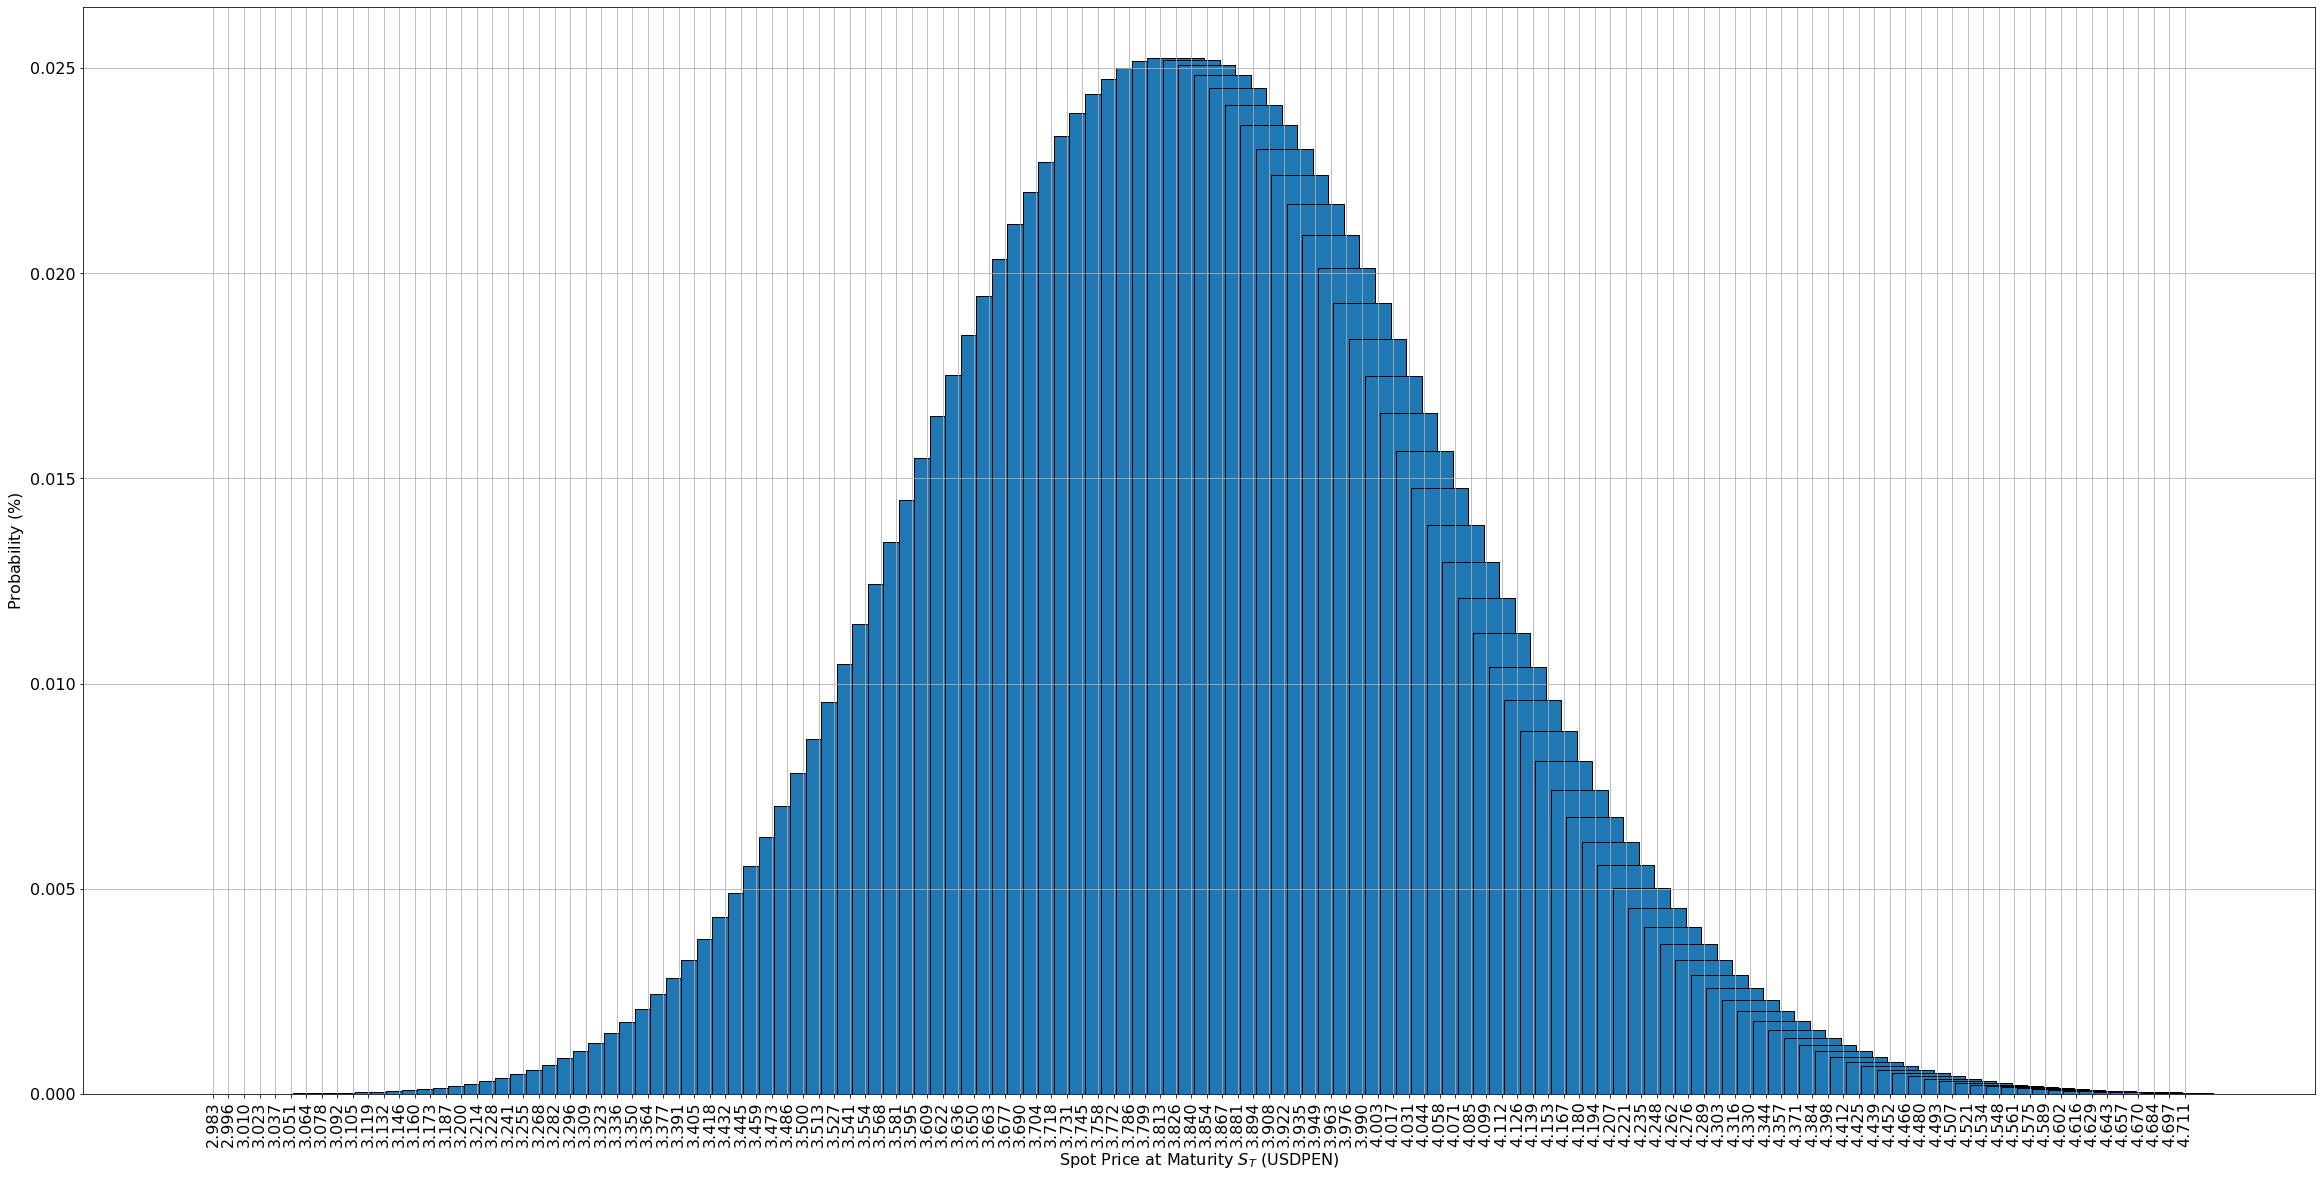

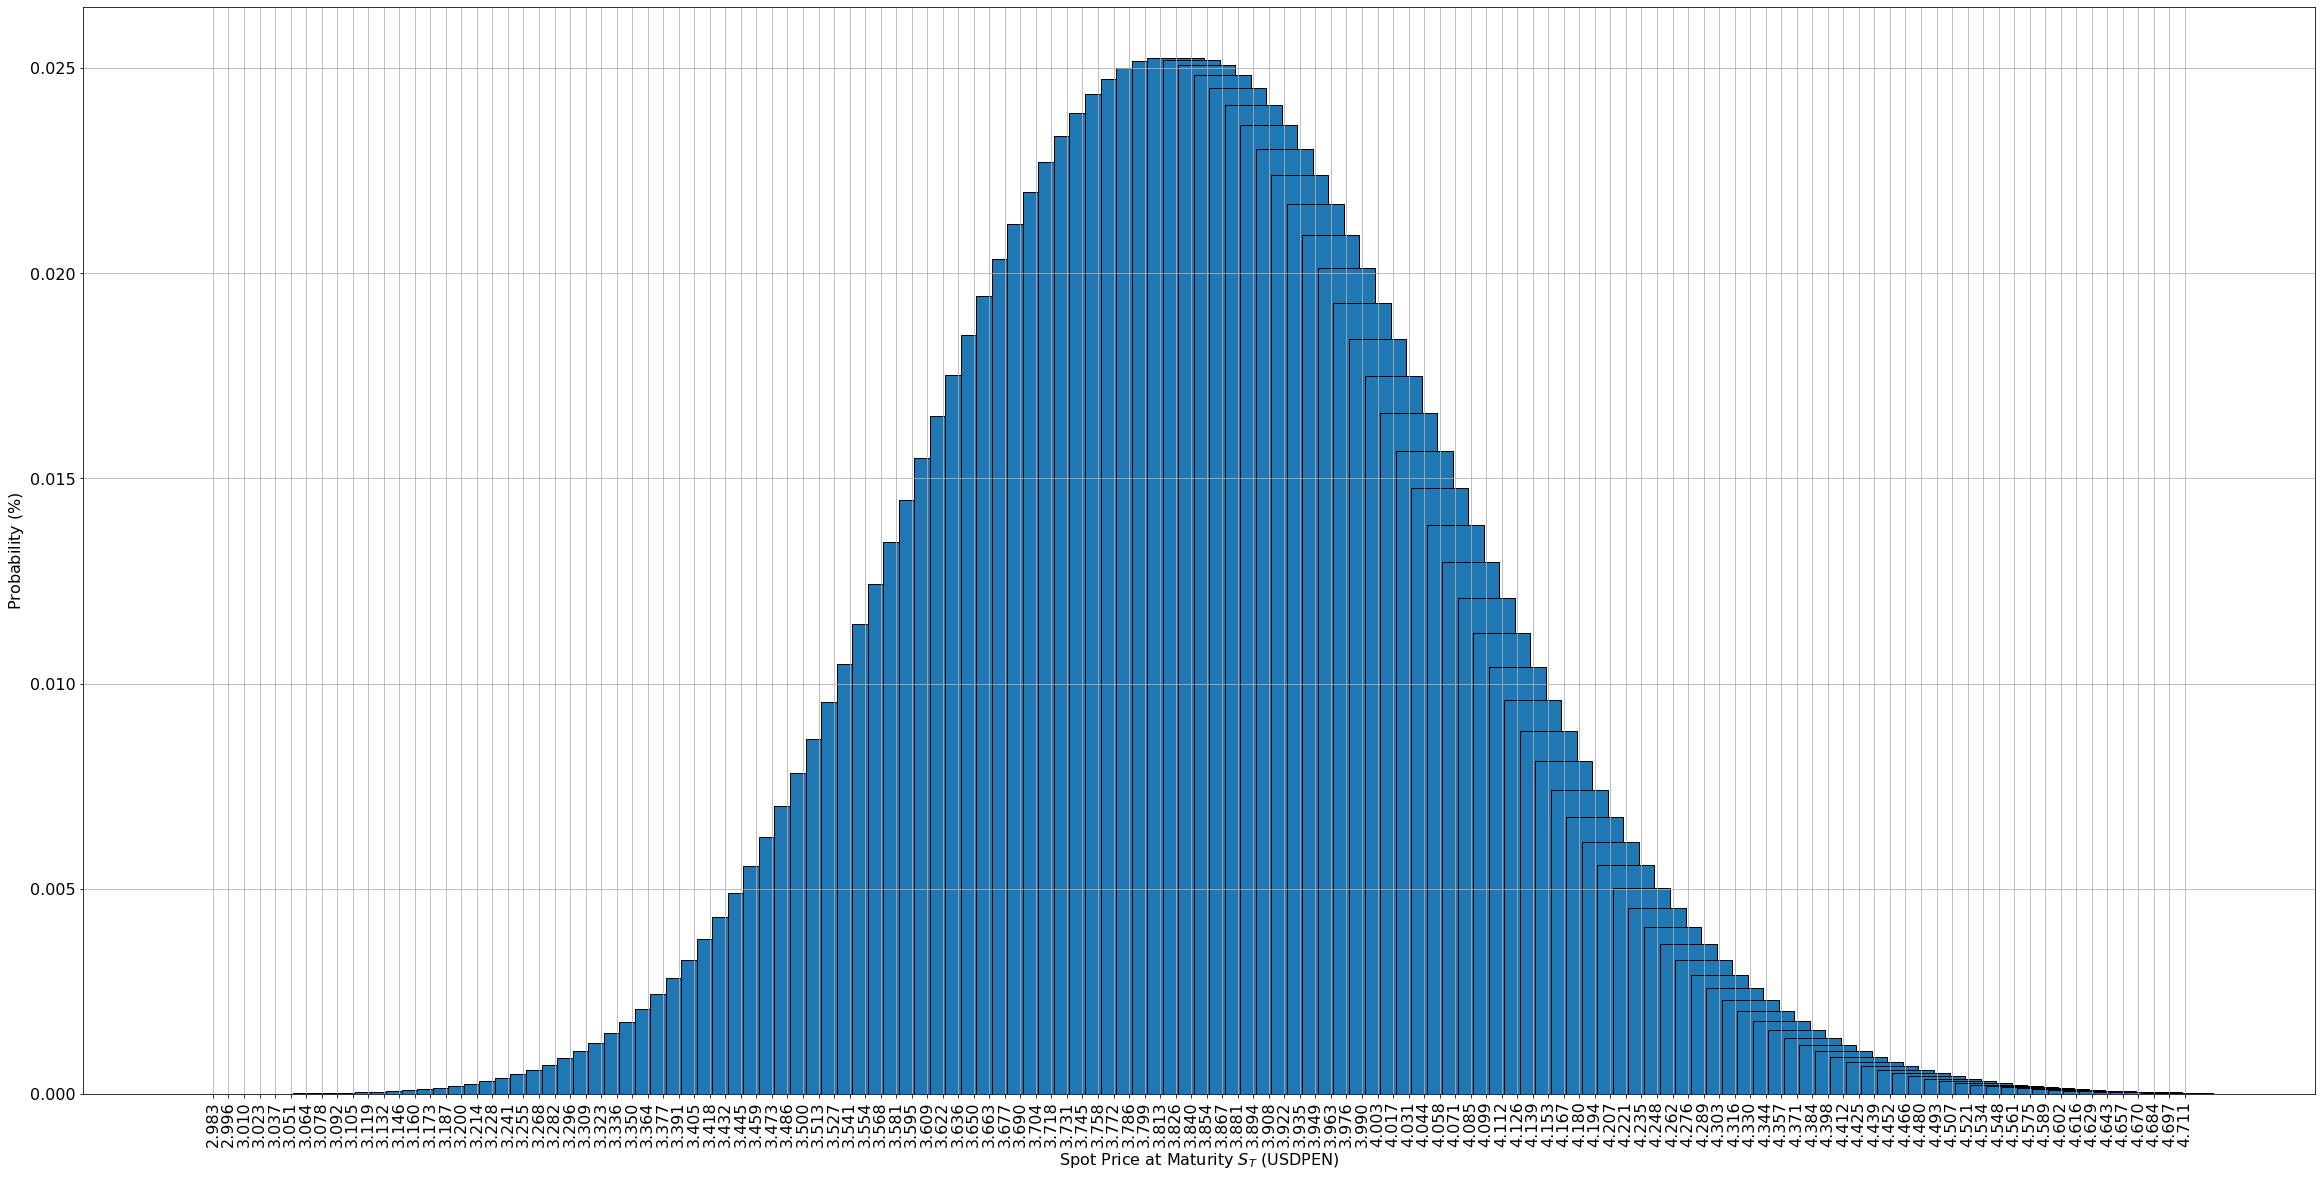

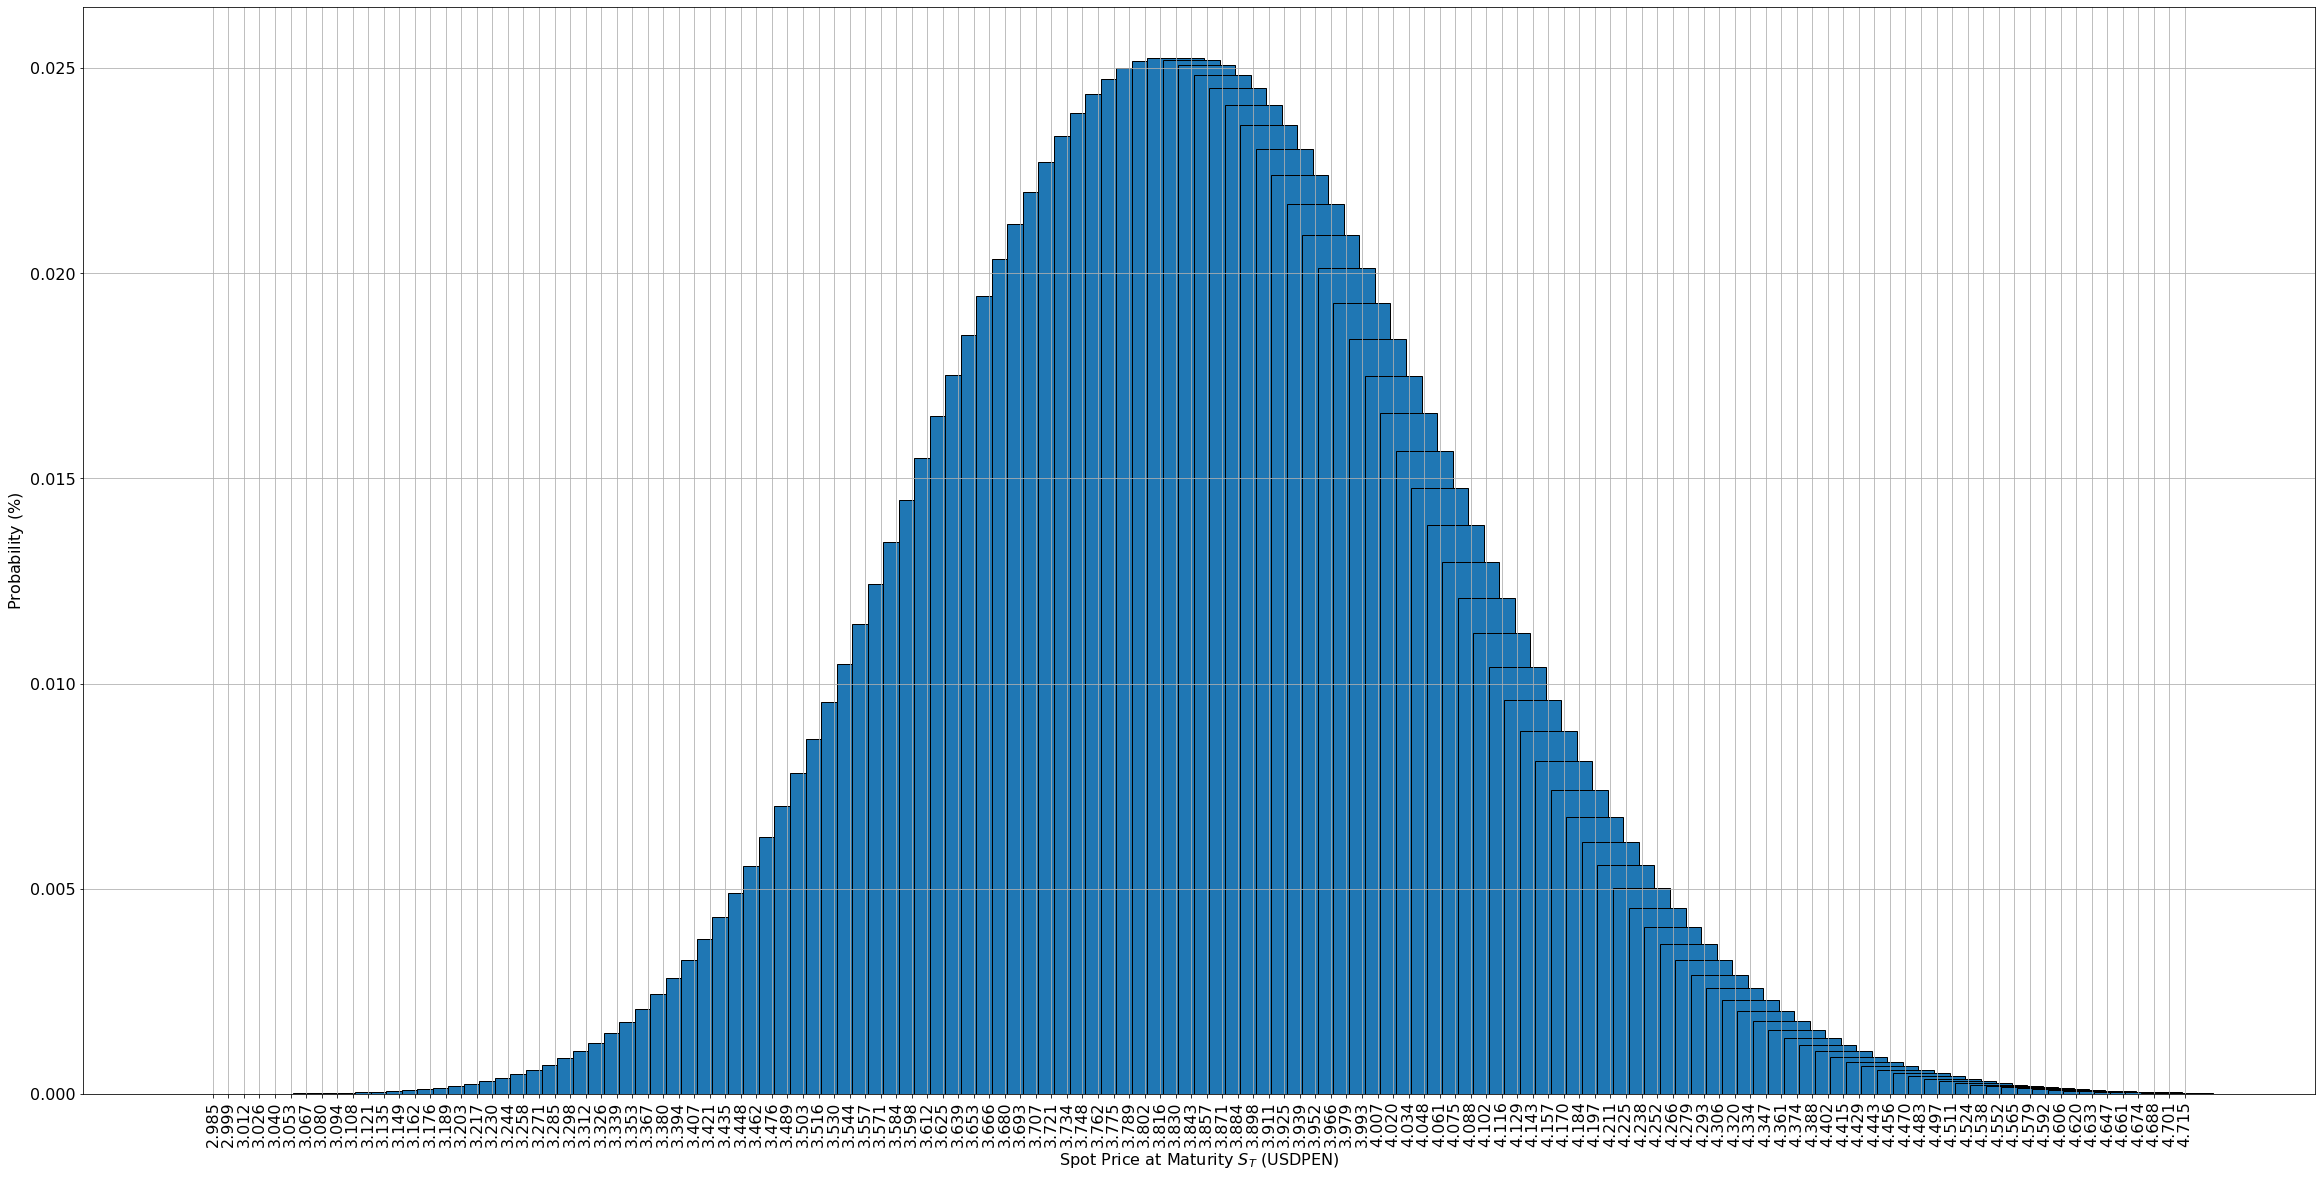

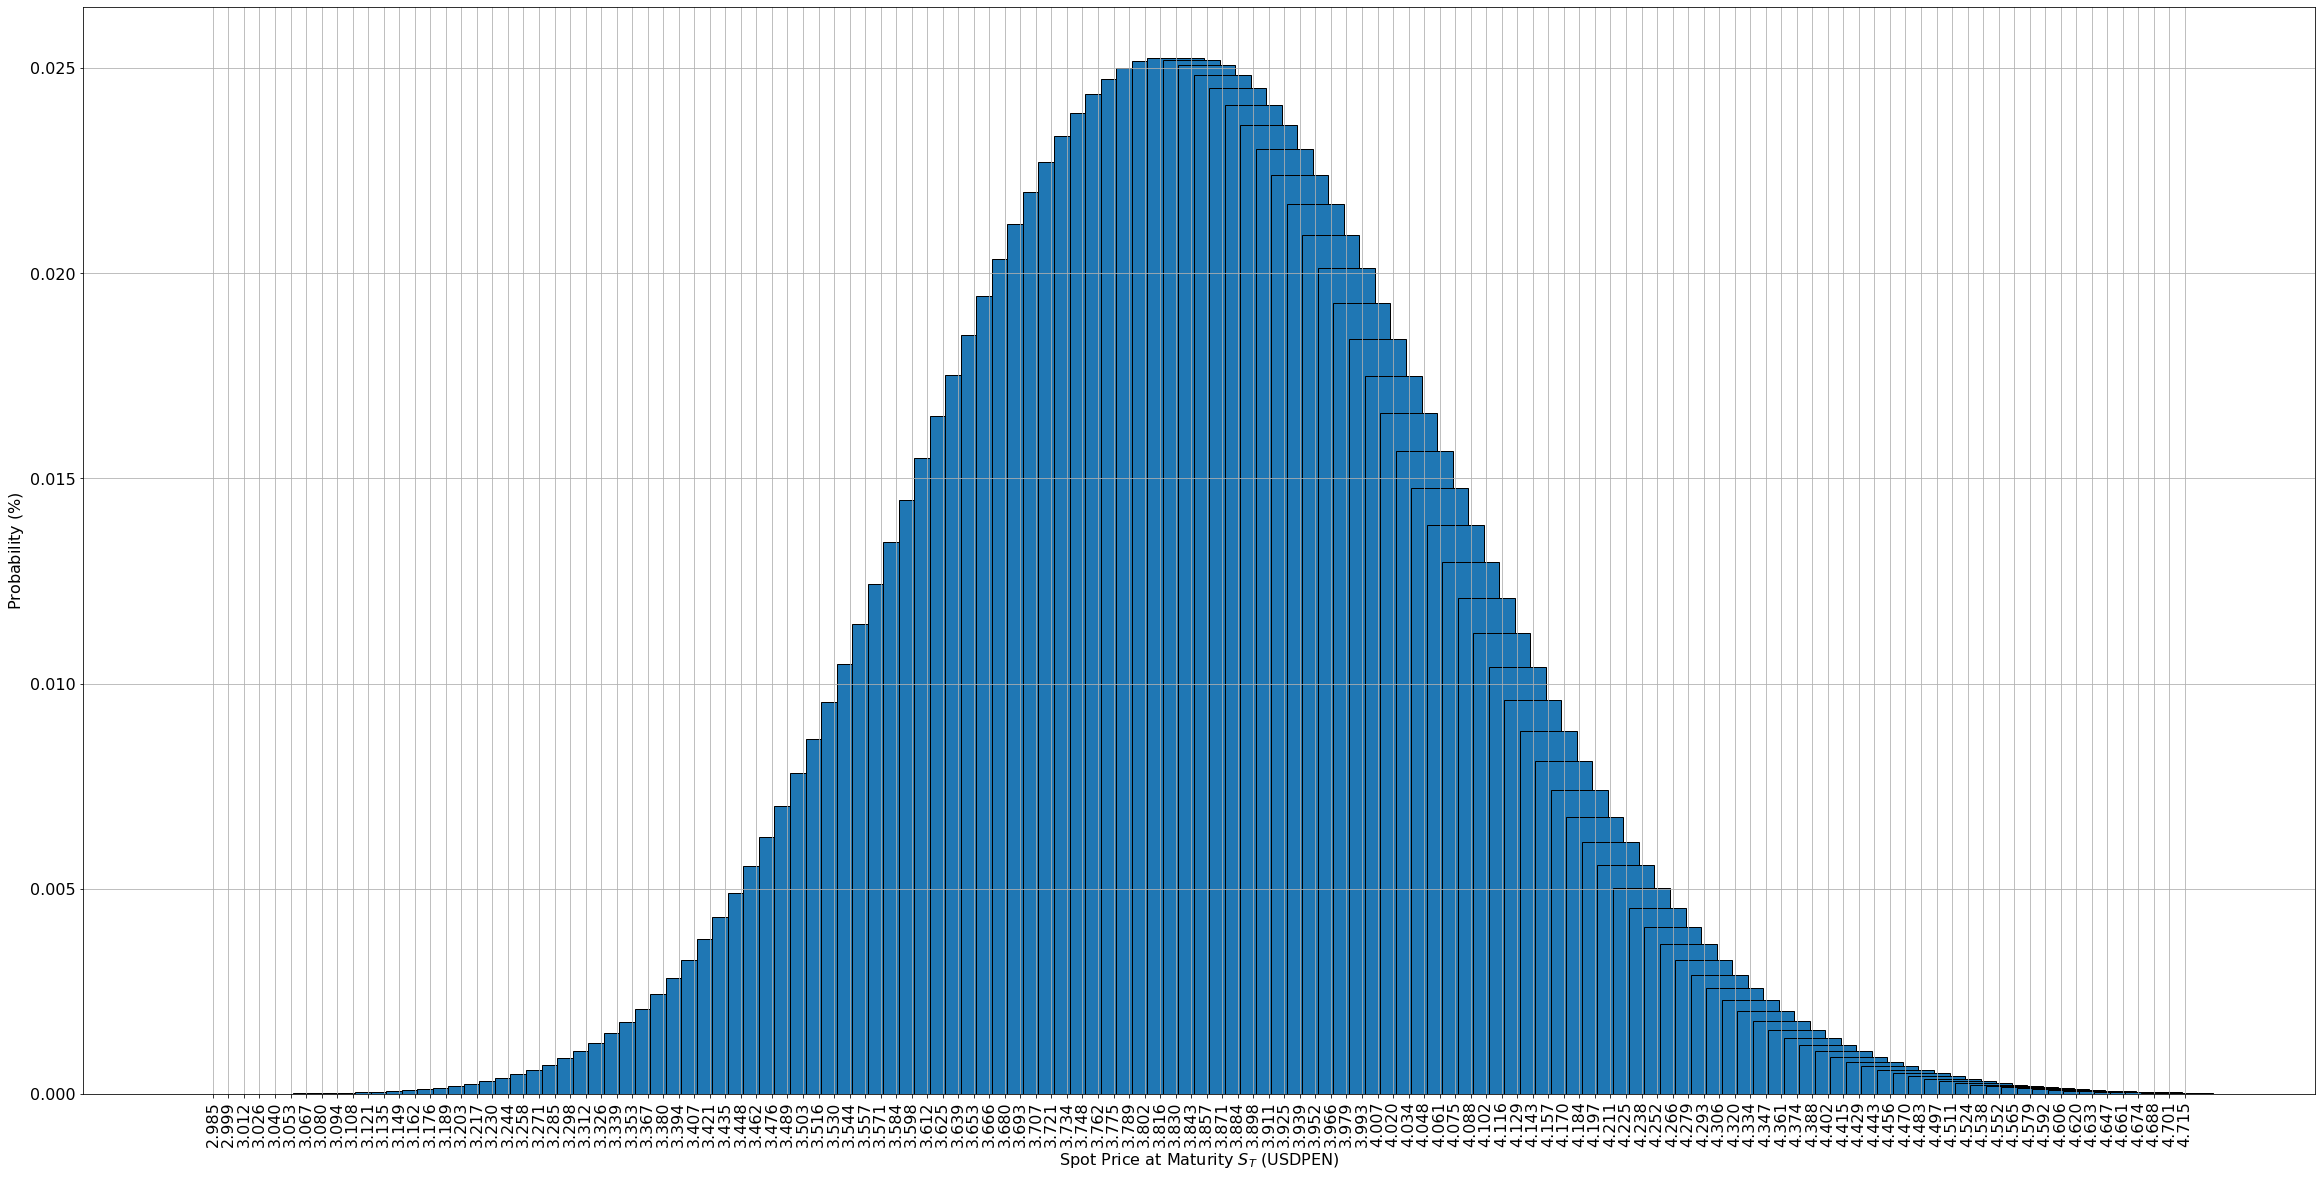

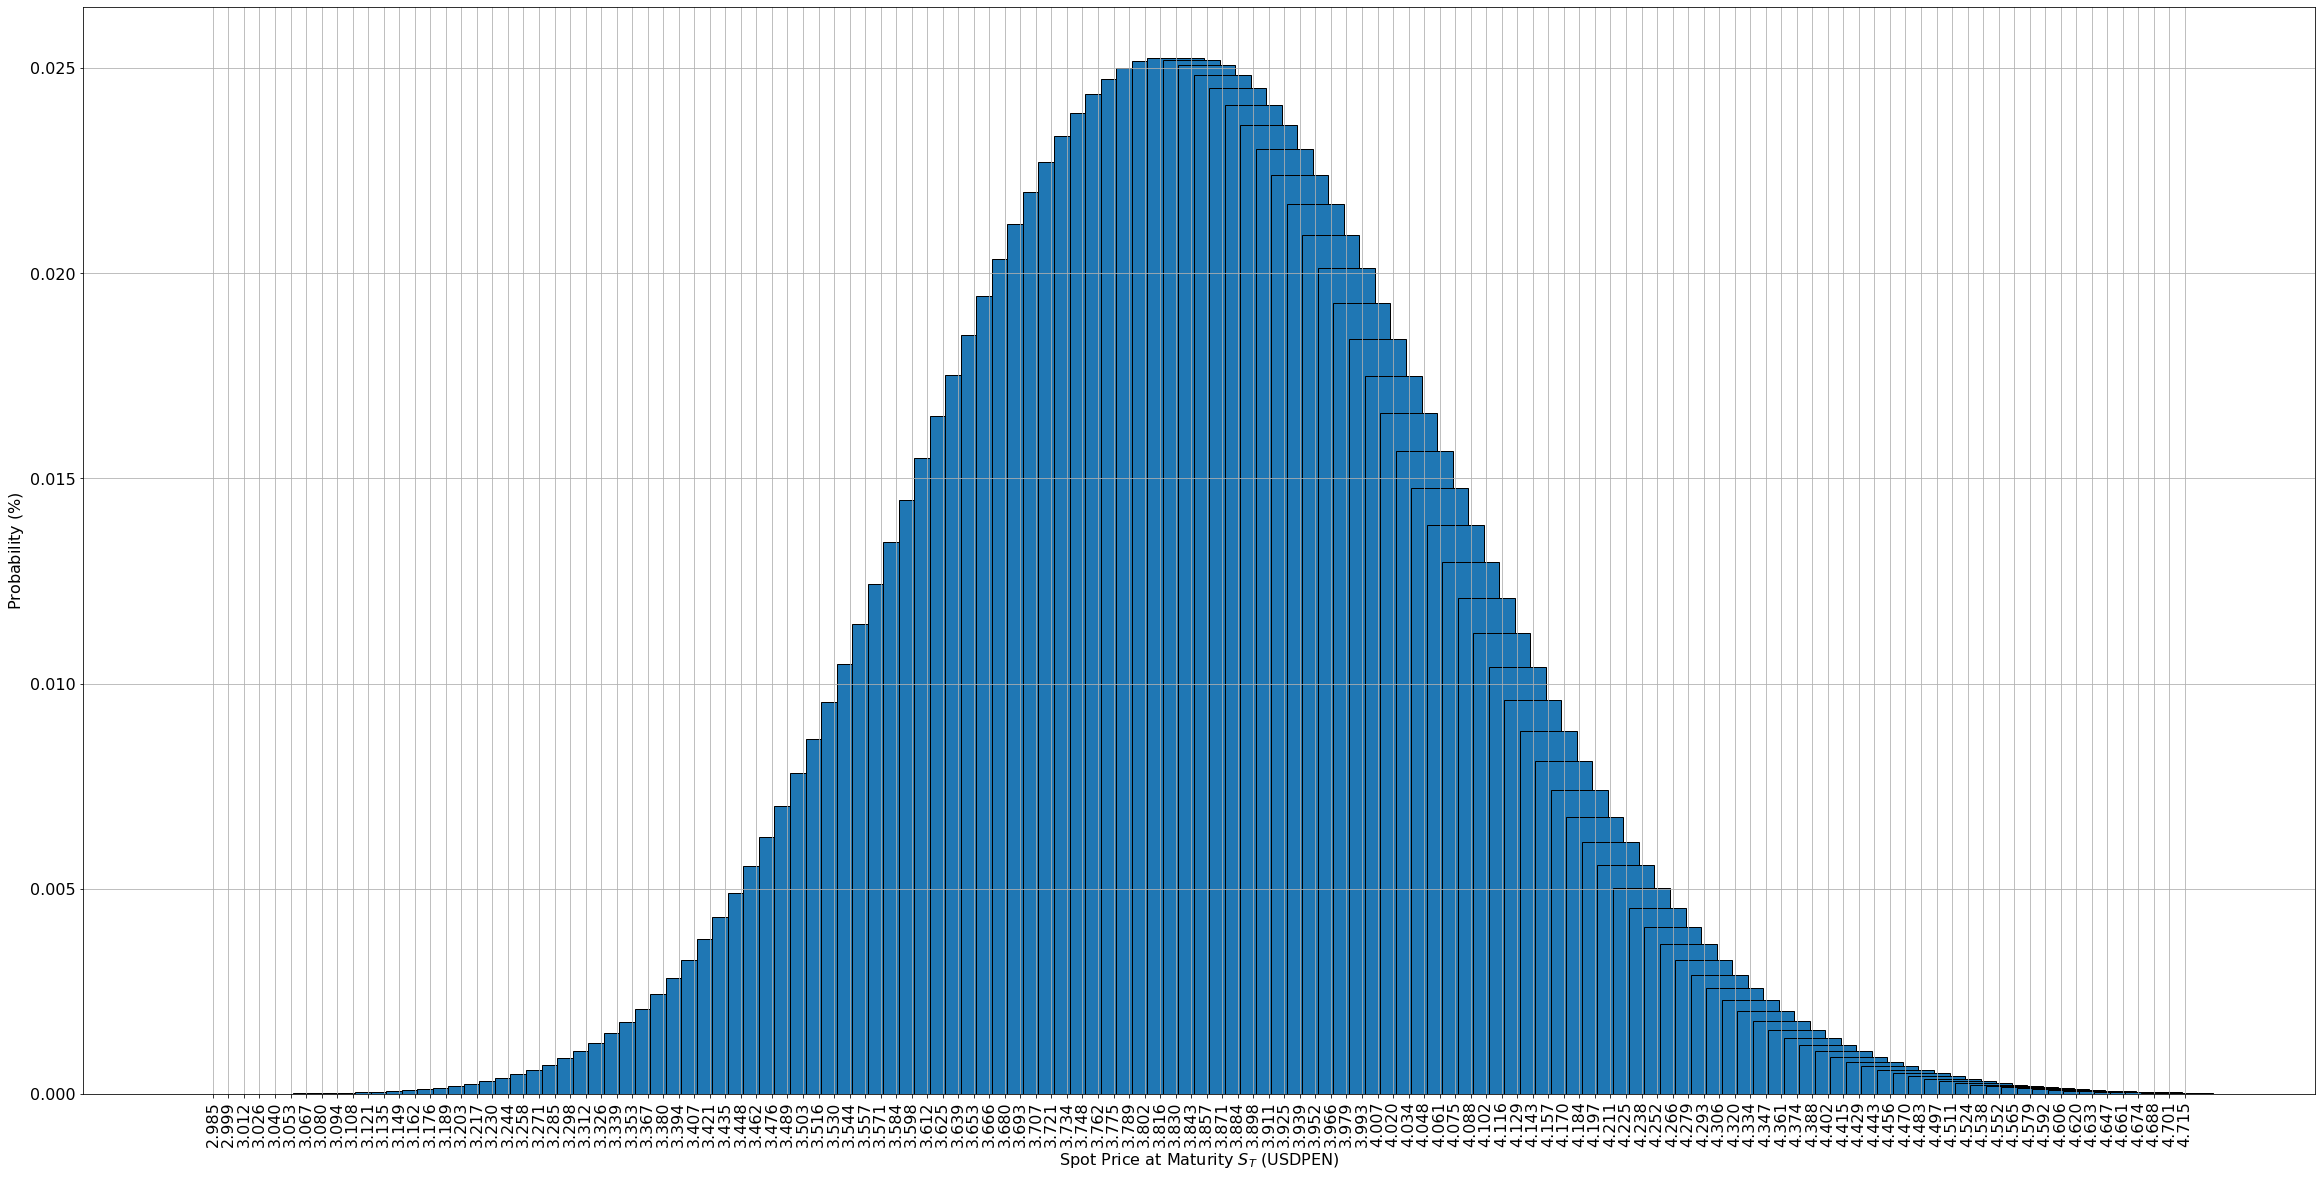

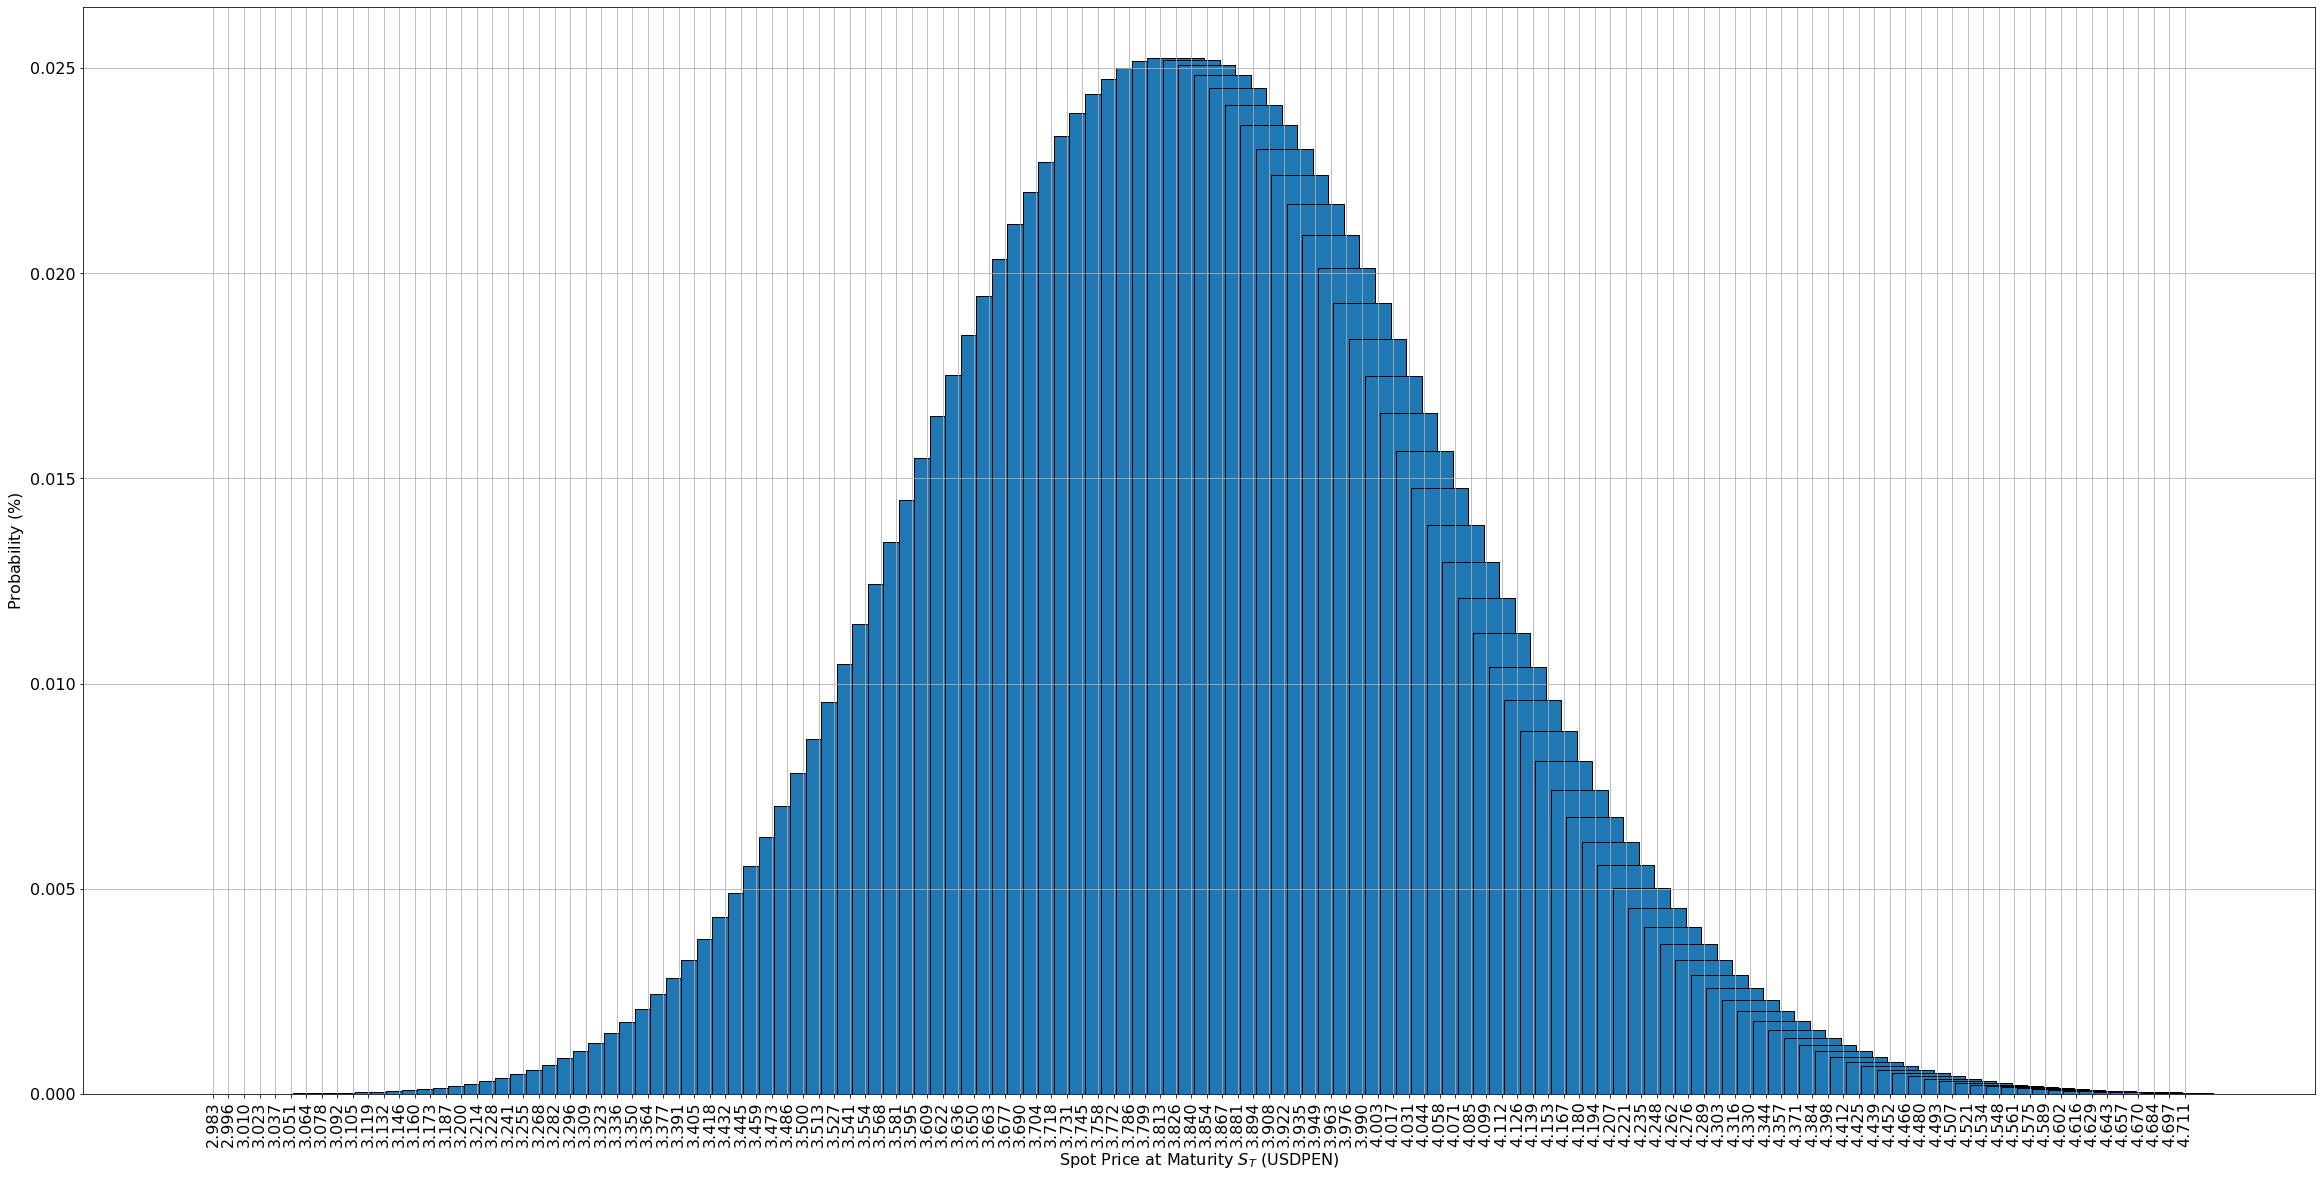

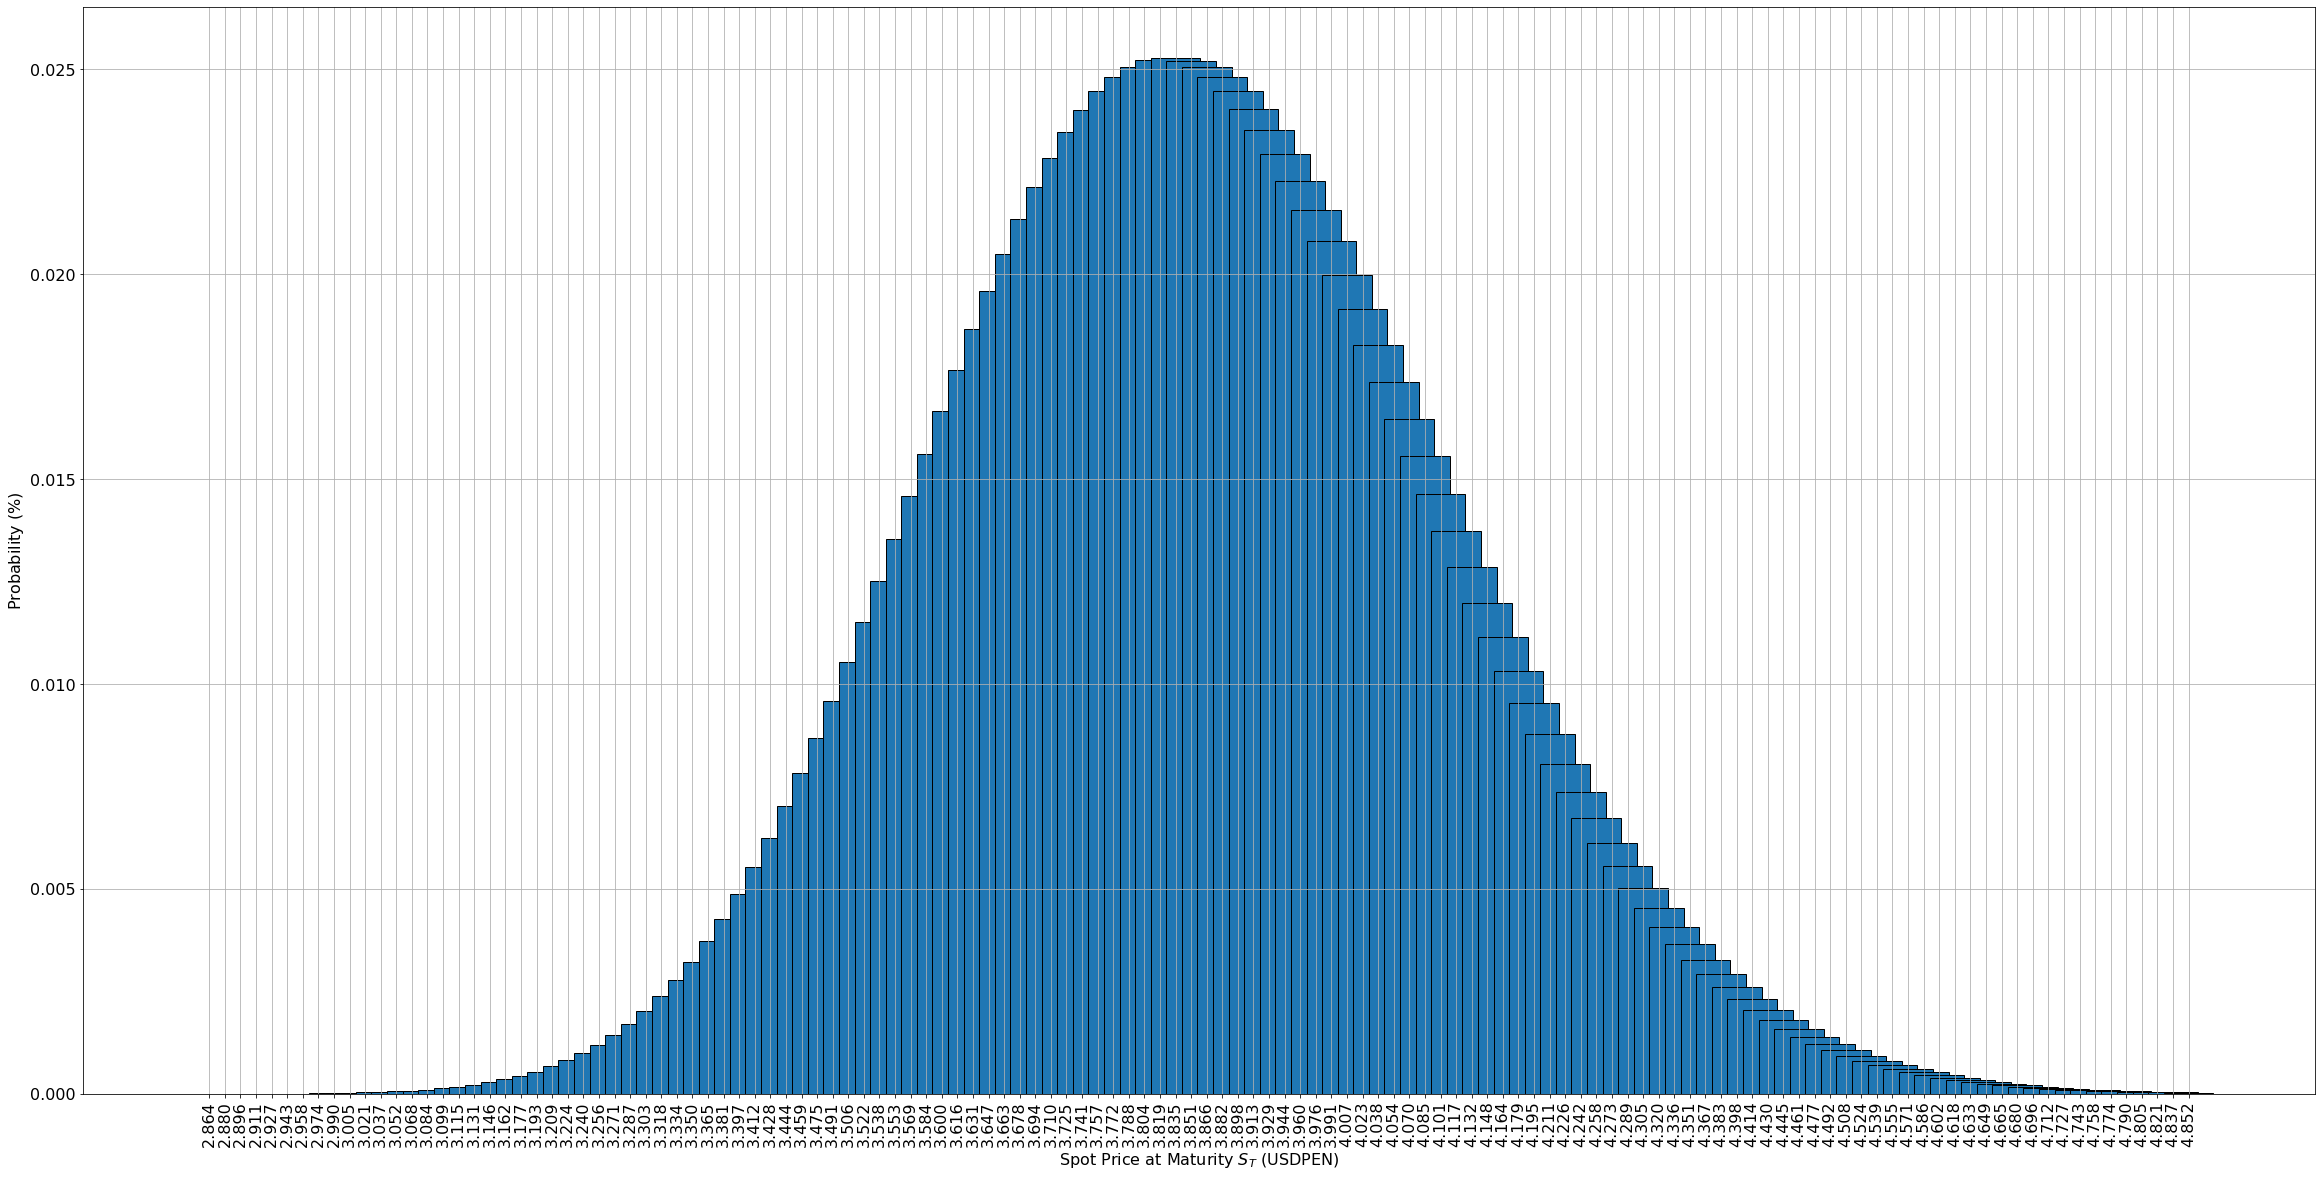

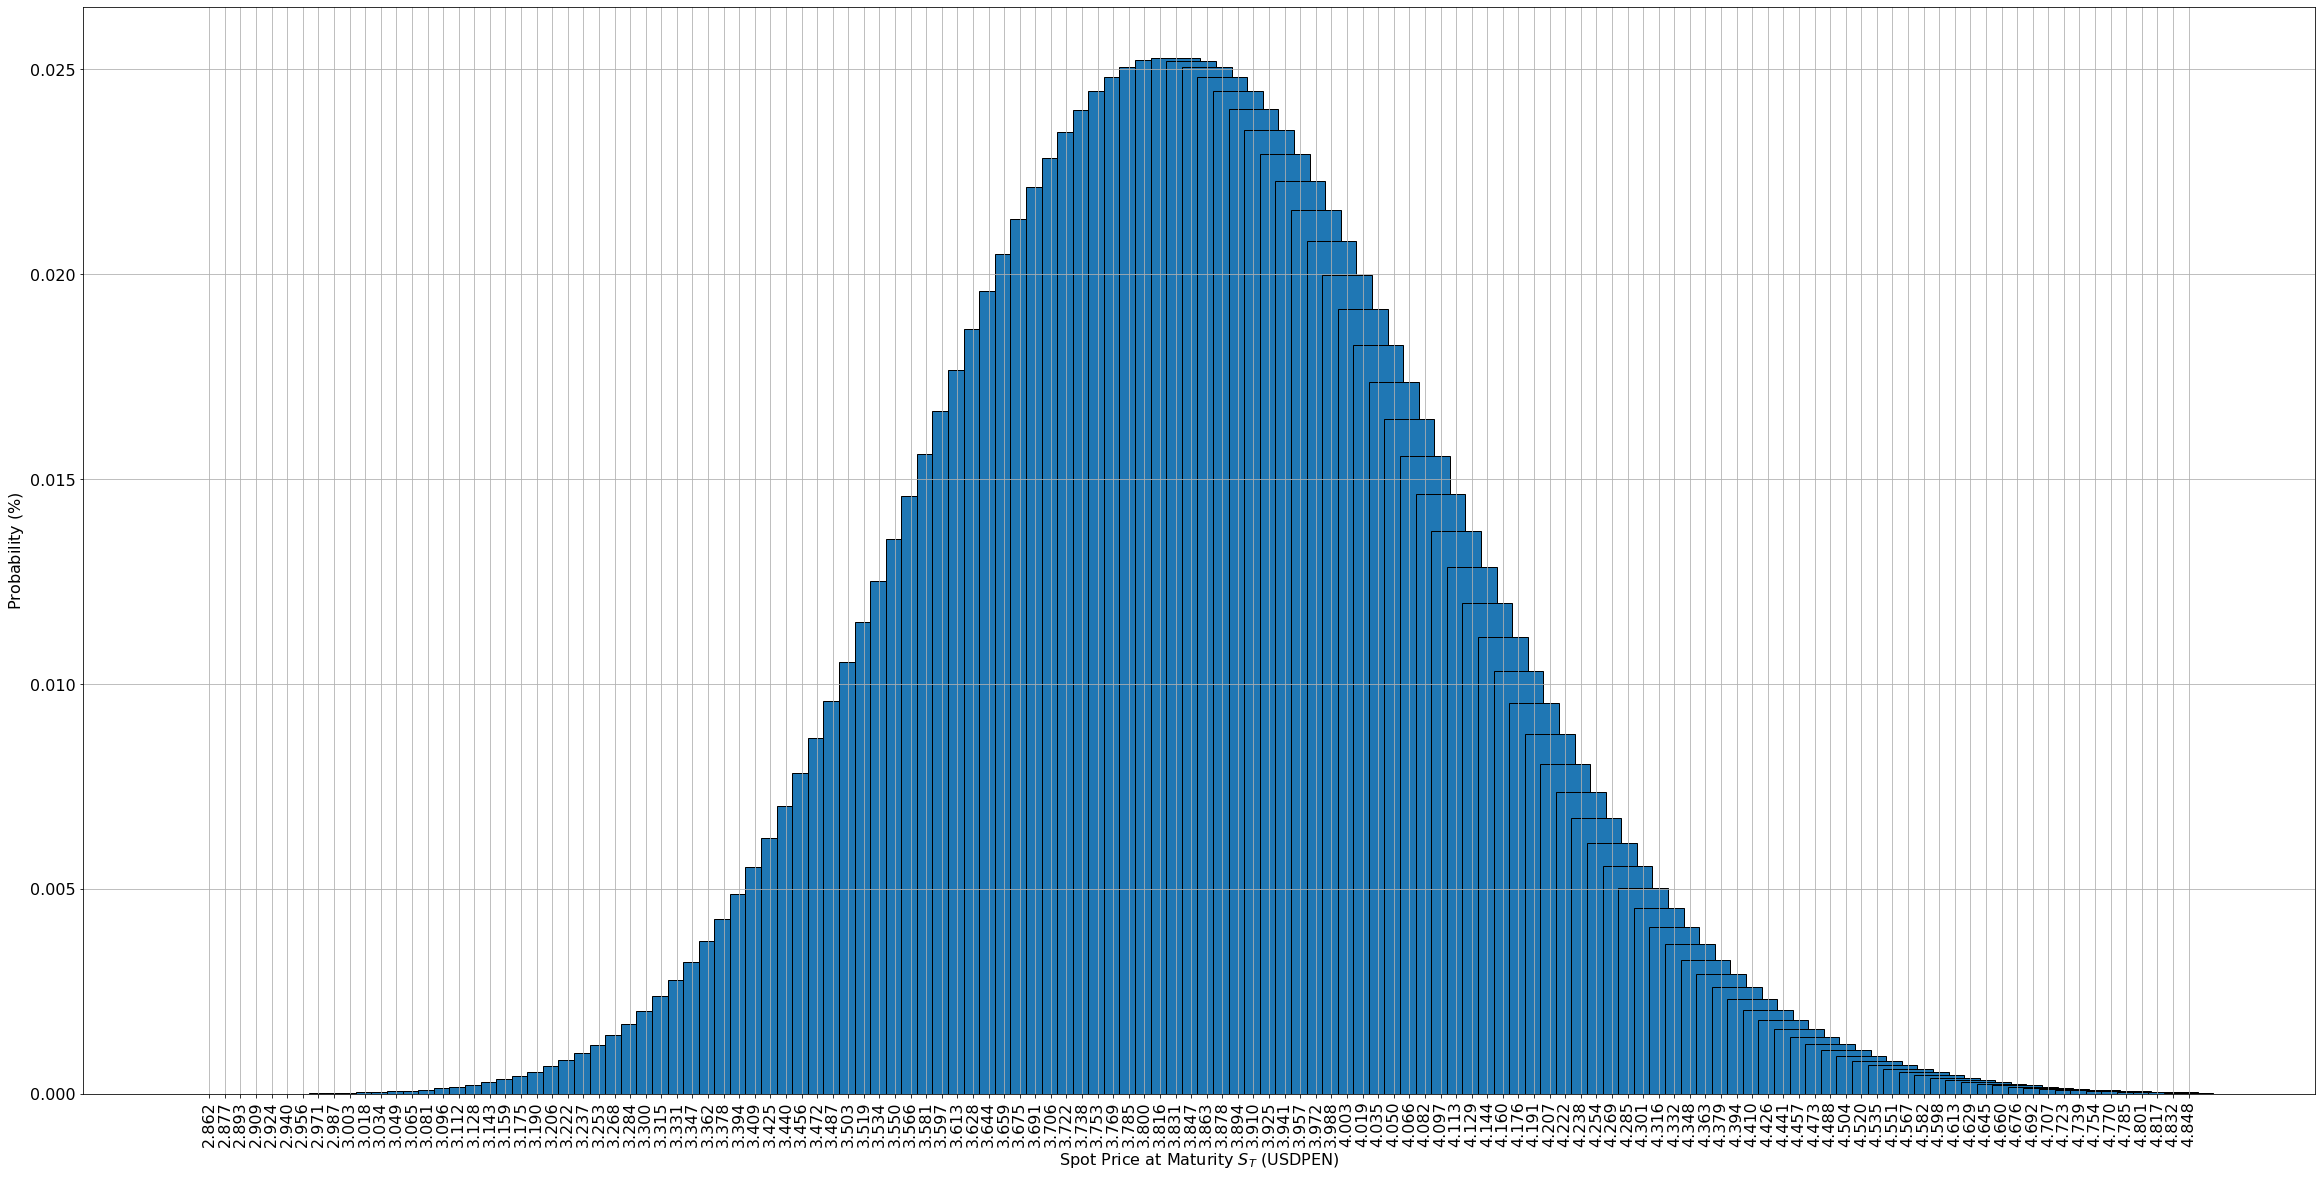

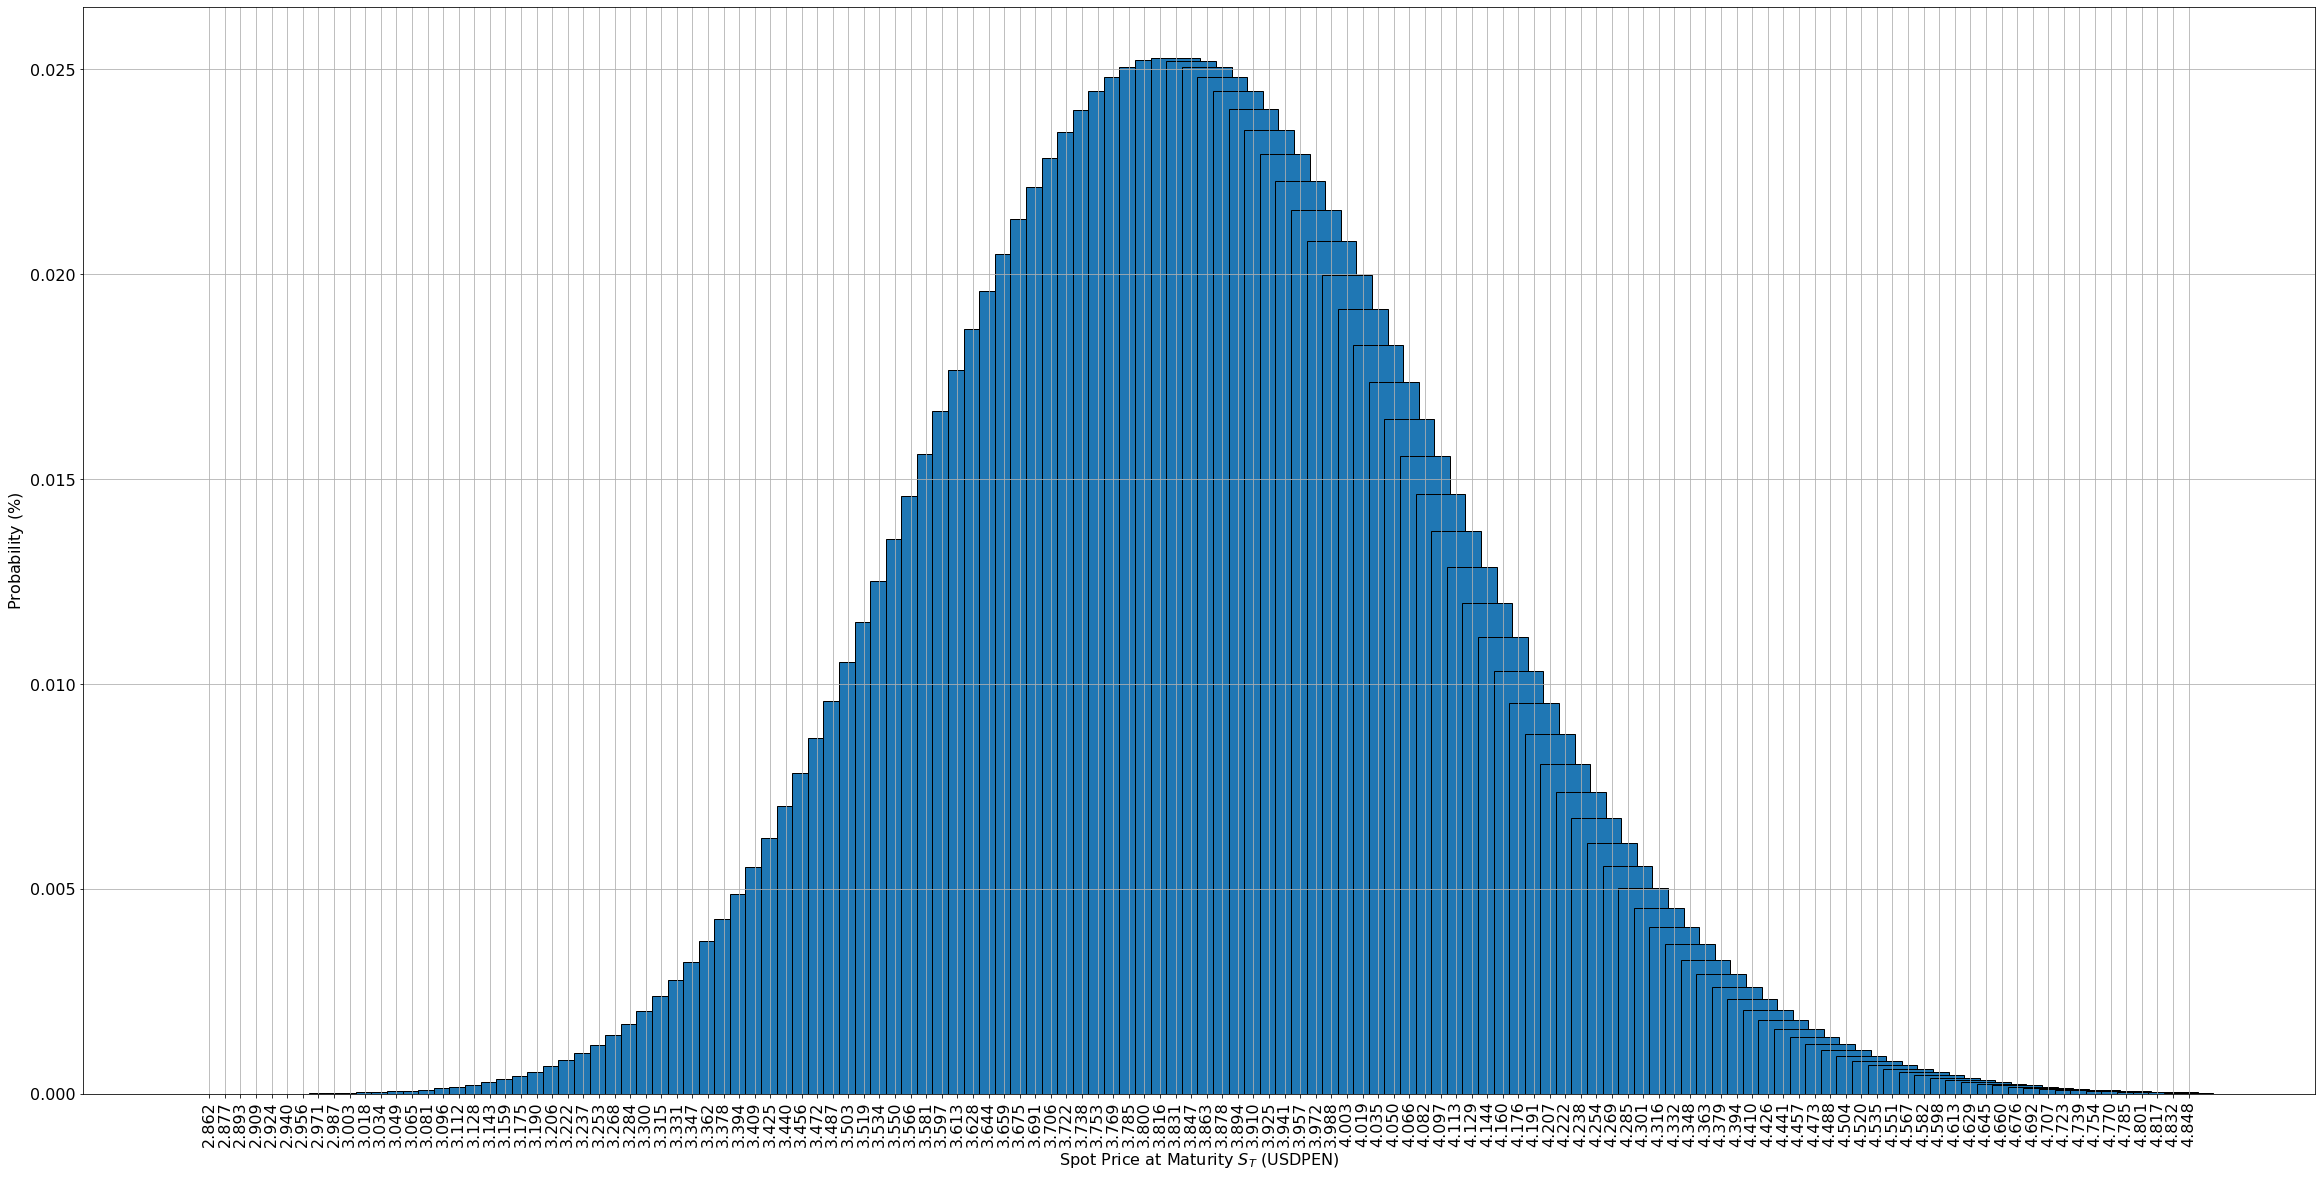

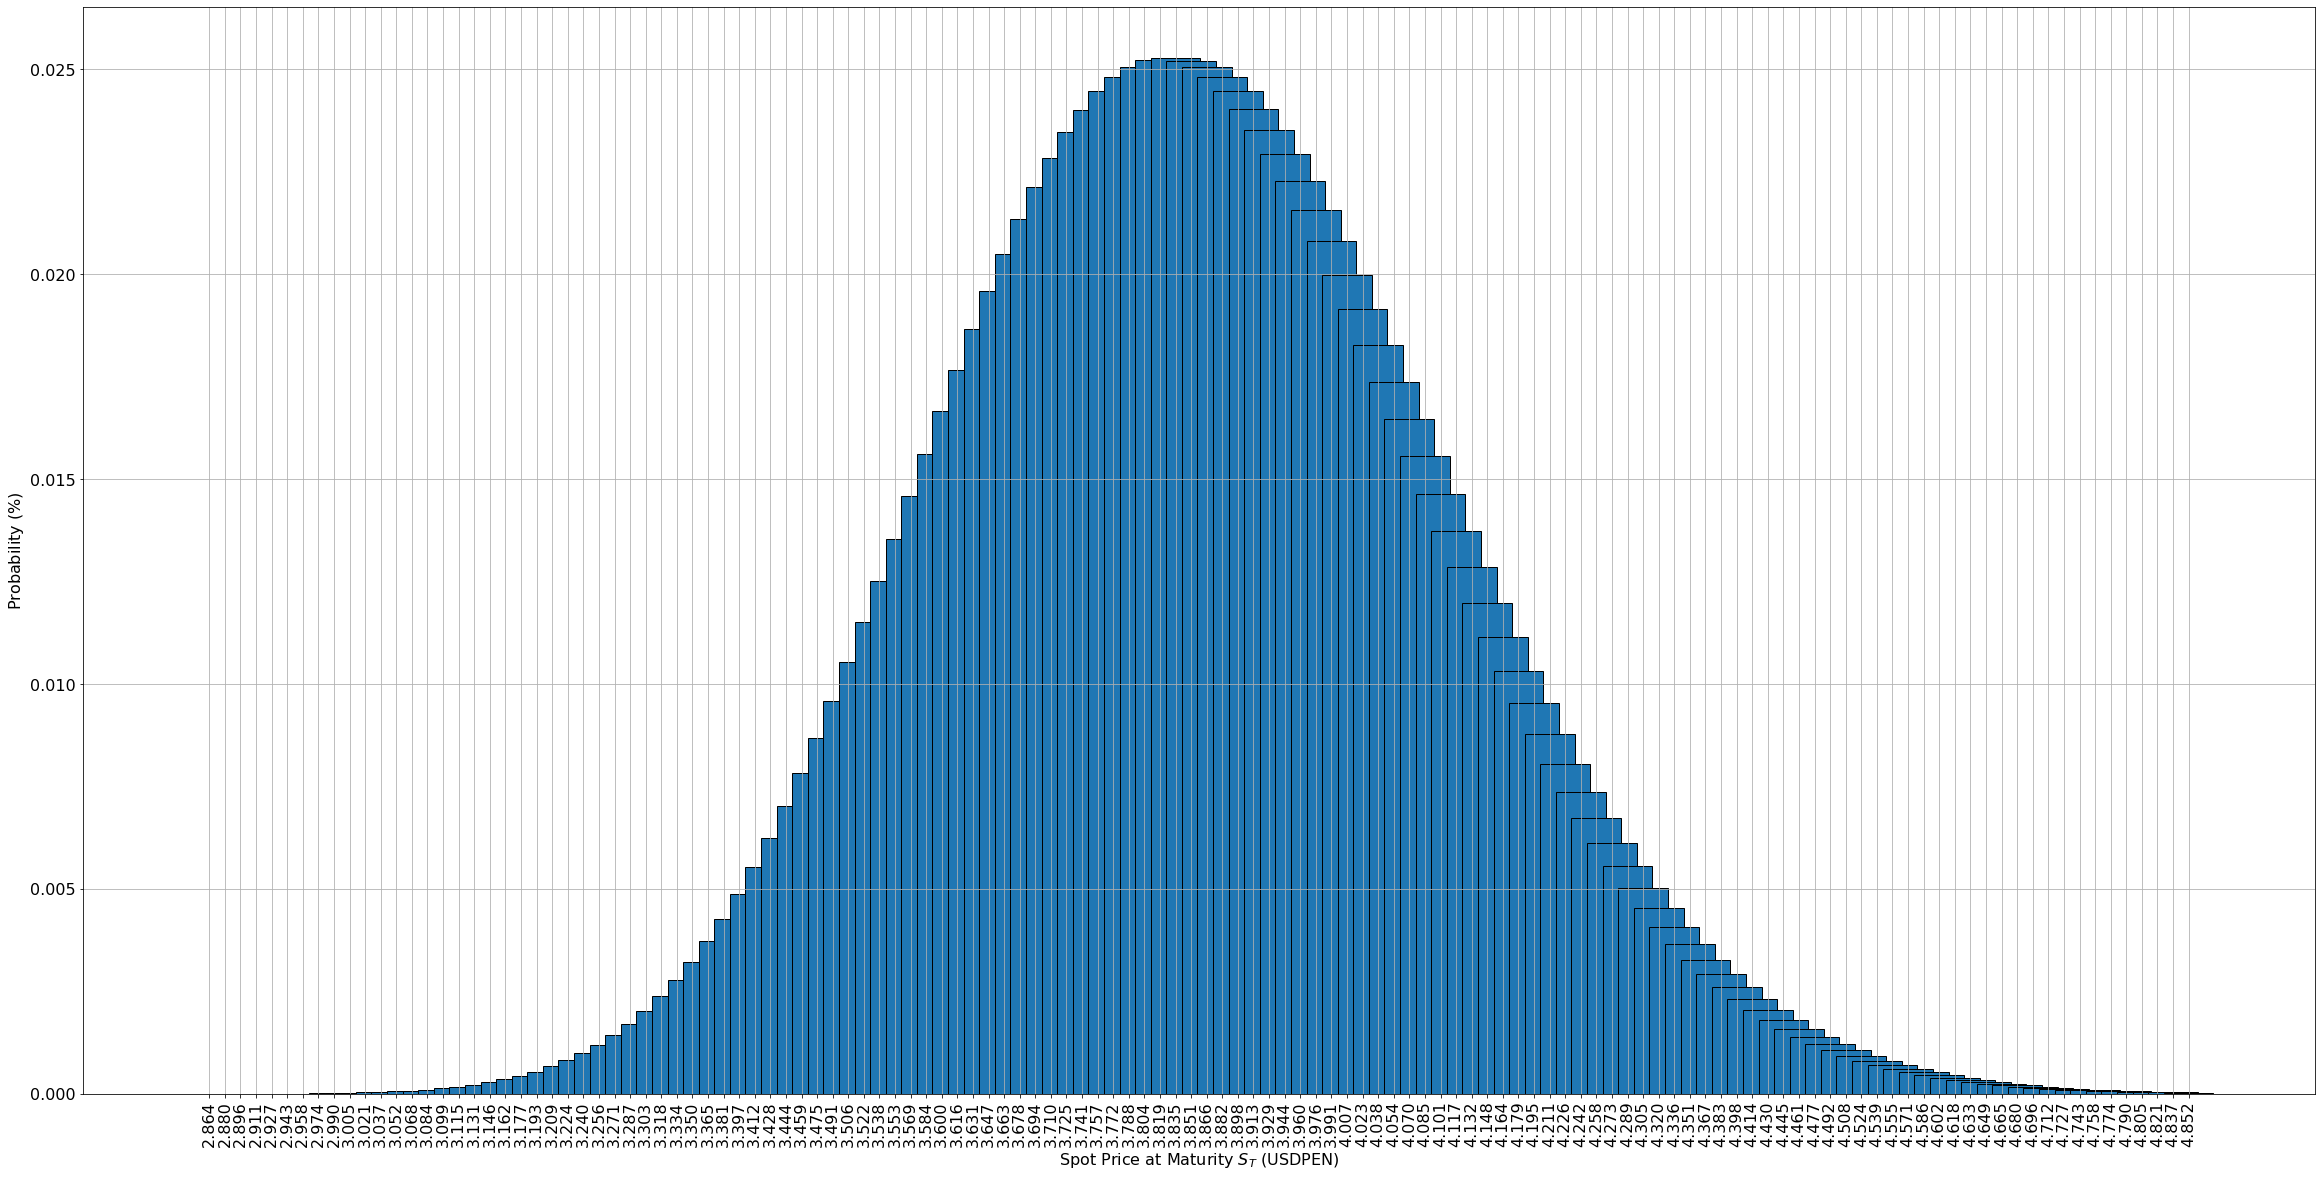

In [481]:
for i in range(len(Clientes_Trading)):
    # plot probability distribution
    x = uncertainty_model[i].values
    y = uncertainty_model[i].probabilities

    plt.figure(figsize=(40,20))

    plt.bar(x, y, width=0.05, edgecolor = 'black')
    plt.xticks(x, size=16, rotation=90)
    plt.yticks(size=16)
    plt.grid()
    plt.xlabel("Spot Price at Maturity $S_T$ (USDPEN)", size=16)
    plt.ylabel("Probability ($\%$)", size=16)
    plt.show()

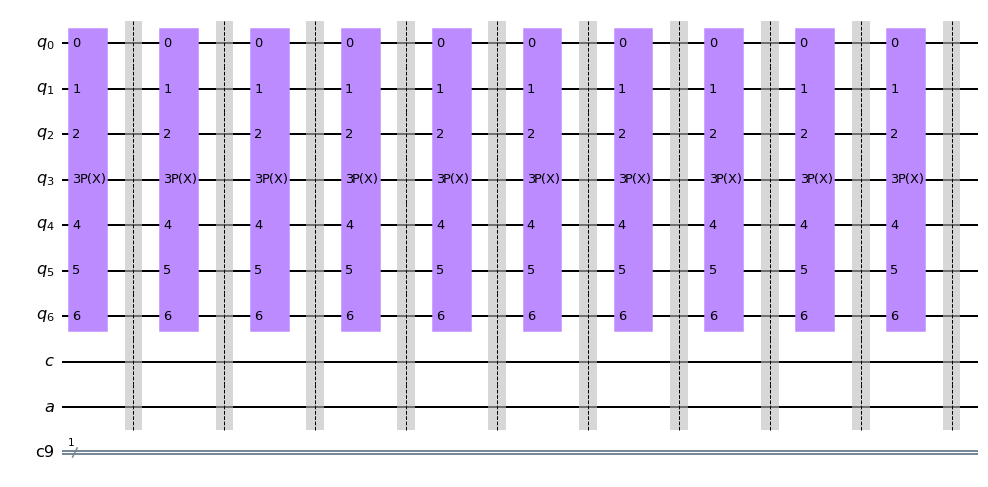

In [482]:
#uncertainty_model.draw('mpl')

# Defining some constants

q = QuantumRegister(num_of_qubits, name = "q")
q_c = QuantumRegister(1, name = "c")
q_a = QuantumRegister(1, name = "a")
c = ClassicalRegister(1)
qc = QuantumCircuit(q, q_c, q_a, c)

for i in range(len(Clientes_Trading)):

    qc.append(uncertainty_model[i], range(num_uncertainty_qubits))
    qc.barrier()

qc.draw("mpl")

In [483]:
psi = Statevector(qc)
psi.draw("latex")

<IPython.core.display.Latex object>

In [484]:
breakpoints = []

for i in range(len(Clientes_Trading)):

    bk = [Clientes_Trading['low'][i], Clientes_Trading['Exercise_Price'][i]]
    breakpoints.append(bk)

print(breakpoints)

[[2.9826366797250112, 4.1], [2.9826366797250112, 4.1], [2.9851515947147576, 3.9], [2.9851515947147576, 3.9], [2.9851515947147576, 3.9], [2.9826366797250112, 4.1], [2.8644074496070244, 3.8], [2.861828704555609, 4.05], [2.861828704555609, 3.95], [2.8644074496070244, 3.85]]


In [485]:
breakpoints

[[2.9826366797250112, 4.1],
 [2.9826366797250112, 4.1],
 [2.9851515947147576, 3.9],
 [2.9851515947147576, 3.9],
 [2.9851515947147576, 3.9],
 [2.9826366797250112, 4.1],
 [2.8644074496070244, 3.8],
 [2.861828704555609, 4.05],
 [2.861828704555609, 3.95],
 [2.8644074496070244, 3.85]]

In [486]:
slopes = [[0, 1]] * len(Clientes_Trading)
offsets = [[0, 0]] * len(Clientes_Trading)
f_min = [0] * len(Clientes_Trading)
f_max = [Clientes_Trading['high'] - Clientes_Trading['Exercise_Price']]

In [487]:
f_max = []

for i in range(len(Clientes_Trading)):
    f1 = Clientes_Trading['high'][i] - Clientes_Trading['Exercise_Price'][i]
    f_max.append(f1)

In [488]:
domain = []

for i in range(len(Clientes_Trading)):
    domination =(Clientes_Trading['low'][i], Clientes_Trading['high'][i])
    domain.append(domination)

print(domain)

[(2.9826366797250112, 4.71105341621322), (2.9826366797250112, 4.71105341621322), (2.9851515947147576, 4.715025706547631), (2.9851515947147576, 4.715025706547631), (2.9851515947147576, 4.715025706547631), (2.9826366797250112, 4.71105341621322), (2.8644074496070244, 4.852382320782885), (2.861828704555609, 4.848013858154075), (2.861828704555609, 4.848013858154075), (2.8644074496070244, 4.852382320782885)]


In [489]:
Clientes_Trading['high']

0    4.711053
1    4.711053
2    4.715026
3    4.715026
4    4.715026
5    4.711053
6    4.852382
7    4.848014
8    4.848014
9    4.852382
Name: high, dtype: float64

In [491]:
breakpoints

[[2.9826366797250112, 4.1],
 [2.9826366797250112, 4.1],
 [2.9851515947147576, 3.9],
 [2.9851515947147576, 3.9],
 [2.9851515947147576, 3.9],
 [2.9826366797250112, 4.1],
 [2.8644074496070244, 3.8],
 [2.861828704555609, 4.05],
 [2.861828704555609, 3.95],
 [2.8644074496070244, 3.85]]

In [492]:
domain

[(2.9826366797250112, 4.71105341621322),
 (2.9826366797250112, 4.71105341621322),
 (2.9851515947147576, 4.715025706547631),
 (2.9851515947147576, 4.715025706547631),
 (2.9851515947147576, 4.715025706547631),
 (2.9826366797250112, 4.71105341621322),
 (2.8644074496070244, 4.852382320782885),
 (2.861828704555609, 4.848013858154075),
 (2.861828704555609, 4.848013858154075),
 (2.8644074496070244, 4.852382320782885)]

In [435]:
#domain2 = domain
#domain2[0] = (3.693420603542732, 4.215456142984521)
#domain2[1] = (3.693420603542732, 4.215456142984521)
#domain2[2] = (3.693420603542732, 4.287564974562164)
#domain2

[(3.693420603542732, 4.215456142984521),
 (3.693420603542732, 4.215456142984521),
 (3.693420603542732, 4.287564974562164),
 (2.9851515947147576, 4.715025706547631),
 (2.9826366797250112, 4.71105341621322),
 (2.9826366797250112, 4.71105341621322),
 (2.9826366797250112, 4.71105341621322),
 (2.9851515947147576, 4.715025706547631),
 (2.9851515947147576, 4.715025706547631),
 (2.9851515947147576, 4.715025706547631),
 (2.9826366797250112, 4.71105341621322),
 (2.8644074496070244, 4.852382320782885),
 (2.861828704555609, 4.848013858154075),
 (2.861828704555609, 4.848013858154075),
 (2.8644074496070244, 4.852382320782885)]

In [436]:
domain = domain2
domain

[(3.693420603542732, 4.215456142984521),
 (3.693420603542732, 4.215456142984521),
 (3.693420603542732, 4.287564974562164),
 (2.9851515947147576, 4.715025706547631),
 (2.9826366797250112, 4.71105341621322),
 (2.9826366797250112, 4.71105341621322),
 (2.9826366797250112, 4.71105341621322),
 (2.9851515947147576, 4.715025706547631),
 (2.9851515947147576, 4.715025706547631),
 (2.9851515947147576, 4.715025706547631),
 (2.9826366797250112, 4.71105341621322),
 (2.8644074496070244, 4.852382320782885),
 (2.861828704555609, 4.848013858154075),
 (2.861828704555609, 4.848013858154075),
 (2.8644074496070244, 4.852382320782885)]

In [493]:
european_call_objective = []

In [438]:
domain

[(3.693420603542732, 4.215456142984521),
 (3.693420603542732, 4.215456142984521),
 (3.693420603542732, 4.287564974562164),
 (2.9851515947147576, 4.715025706547631),
 (2.9826366797250112, 4.71105341621322),
 (2.9826366797250112, 4.71105341621322),
 (2.9826366797250112, 4.71105341621322),
 (2.9851515947147576, 4.715025706547631),
 (2.9851515947147576, 4.715025706547631),
 (2.9851515947147576, 4.715025706547631),
 (2.9826366797250112, 4.71105341621322),
 (2.8644074496070244, 4.852382320782885),
 (2.861828704555609, 4.848013858154075),
 (2.861828704555609, 4.848013858154075),
 (2.8644074496070244, 4.852382320782885)]

In [439]:
breakpoints

[[3.738944112938505, 4.1],
 [3.738944112938505, 4.1],
 [3.738944112938505, 4.2],
 [2.9851515947147576, 3.9],
 [2.9826366797250112, 4.1],
 [2.9826366797250112, 4.1],
 [2.9826366797250112, 4.1],
 [2.9851515947147576, 3.9],
 [2.9851515947147576, 3.9],
 [2.9851515947147576, 3.9],
 [2.9826366797250112, 4.1],
 [2.8644074496070244, 3.8],
 [2.861828704555609, 4.05],
 [2.861828704555609, 3.95],
 [2.8644074496070244, 3.85]]

In [494]:
slopes

[[0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1]]

In [441]:
len(breakpoints)

15

In [442]:
len(slopes)

15

In [443]:
len(offsets)

15

In [495]:
european_call_objective = []

for i in range(len(Clientes_Trading)):

    optionCall = LinearAmplitudeFunction(num_uncertainty_qubits, slopes[i], offsets[i], domain=domain[i], image=(f_min[i], f_max[i]), breakpoints=breakpoints[i], rescaling_factor= c_approx,)
    european_call_objective.append(optionCall)
    print(european_call_objective)

[<qiskit.circuit.library.arithmetic.linear_amplitude_function.LinearAmplitudeFunction object at 0x7f5b3b7cff10>, <qiskit.circuit.library.arithmetic.linear_amplitude_function.LinearAmplitudeFunction object at 0x7f5b3be15a60>]
[<qiskit.circuit.library.arithmetic.linear_amplitude_function.LinearAmplitudeFunction object at 0x7f5b3b7cff10>, <qiskit.circuit.library.arithmetic.linear_amplitude_function.LinearAmplitudeFunction object at 0x7f5b3be15a60>, <qiskit.circuit.library.arithmetic.linear_amplitude_function.LinearAmplitudeFunction object at 0x7f5b4c27d7f0>]
[<qiskit.circuit.library.arithmetic.linear_amplitude_function.LinearAmplitudeFunction object at 0x7f5b3b7cff10>, <qiskit.circuit.library.arithmetic.linear_amplitude_function.LinearAmplitudeFunction object at 0x7f5b3be15a60>, <qiskit.circuit.library.arithmetic.linear_amplitude_function.LinearAmplitudeFunction object at 0x7f5b4c27d7f0>, <qiskit.circuit.library.arithmetic.linear_amplitude_function.LinearAmplitudeFunction object at 0x7f5b

In [496]:
european_call_objective

In [497]:
num_qubits = european_call_objective[0].num_qubits
european_call = QuantumCircuit(num_qubits)

print(num_qubits)
print(european_call)

15
      
 q_0: 
      
 q_1: 
      
 q_2: 
      
 q_3: 
      
 q_4: 
      
 q_5: 
      
 q_6: 
      
 q_7: 
      
 q_8: 
      
 q_9: 
      
q_10: 
      
q_11: 
      
q_12: 
      
q_13: 
      
q_14: 
      


In [498]:
num_qubits

15

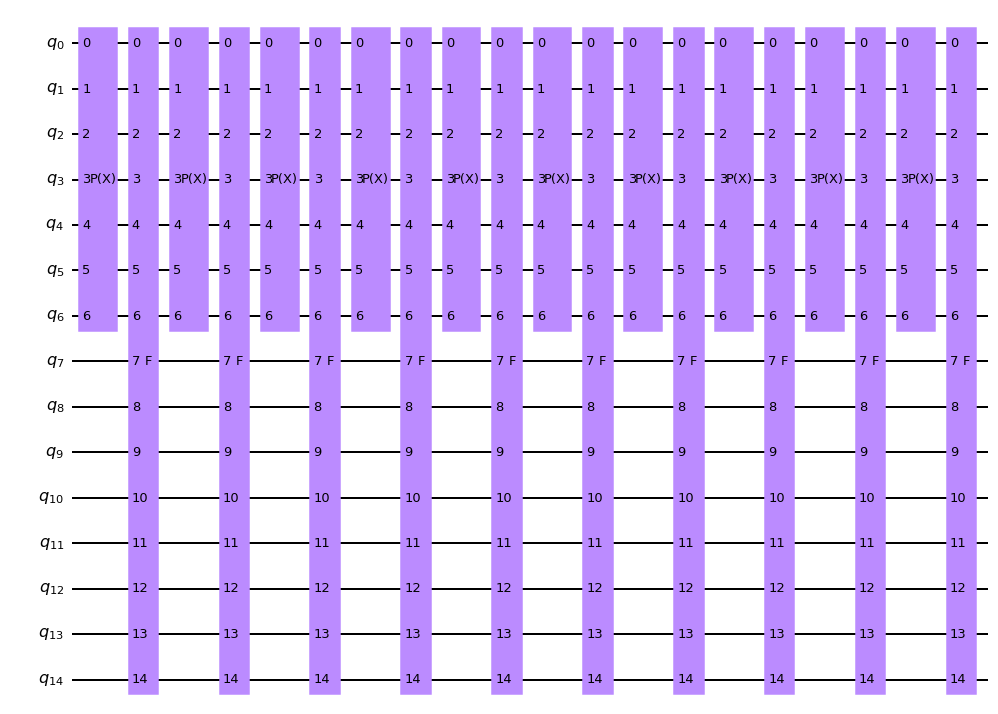

In [499]:
for i in range(len(Clientes_Trading)):
    
    european_call.append(uncertainty_model[i], range(num_uncertainty_qubits))
    european_call.append(european_call_objective[i], range(num_qubits))

european_call.draw()

In [500]:
european_call

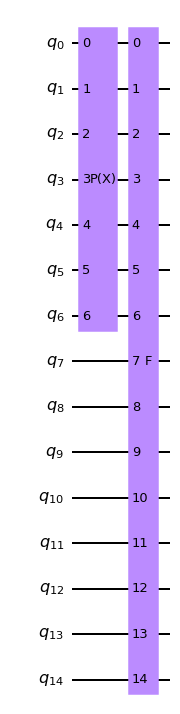

In [501]:
# This is fu**ing OK!

num_qubits = []

european_call=[]

for i in range(len(Clientes_Trading)):
    
    nQbits = european_call_objective[i].num_qubits
    num_qubits.append(nQbits)
    
    euroCall = QuantumCircuit(num_qubits[i])
    euroCall.append(uncertainty_model[i], range(num_uncertainty_qubits))
    euroCall.append(european_call_objective[i], range(nQbits))
    
    #print(euroCall)
    european_call.append(euroCall)
    
                    
                    
european_call[0].draw()
european_call[1].draw()
    
#print(nQbits)

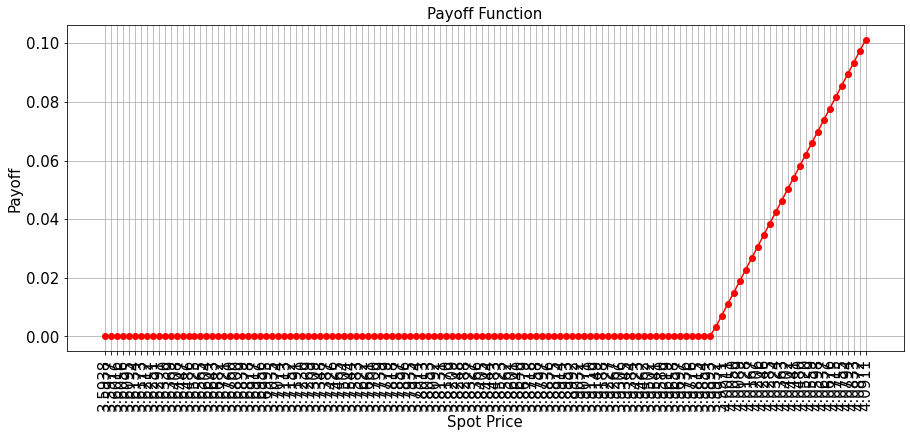

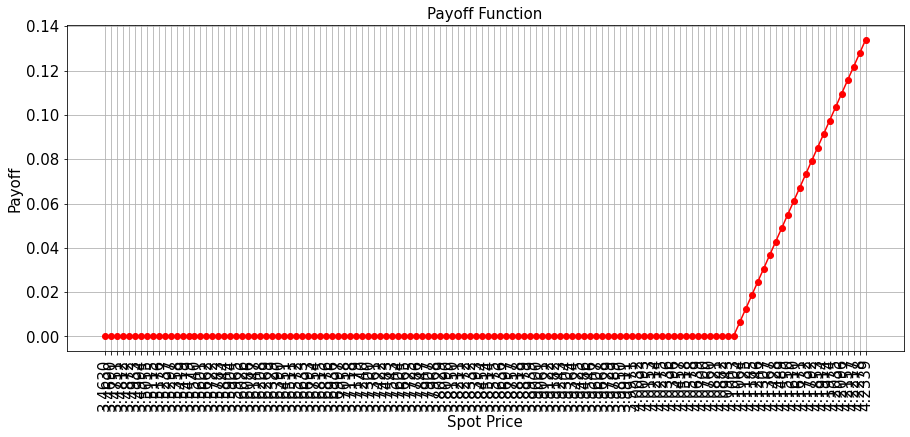

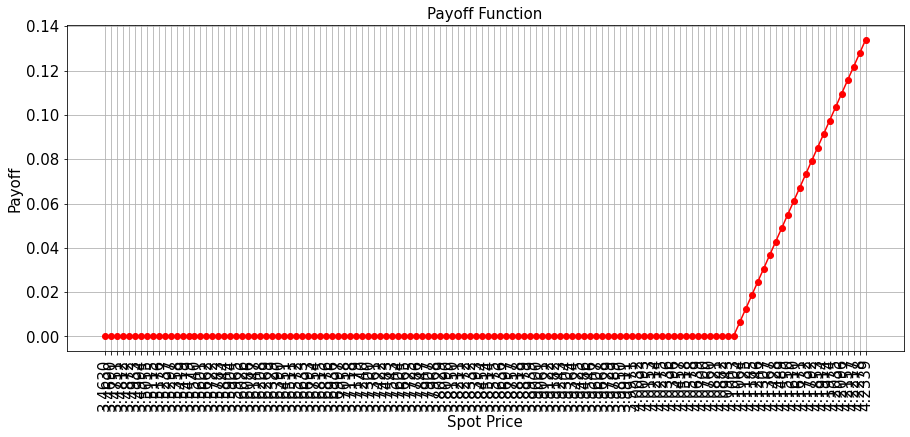

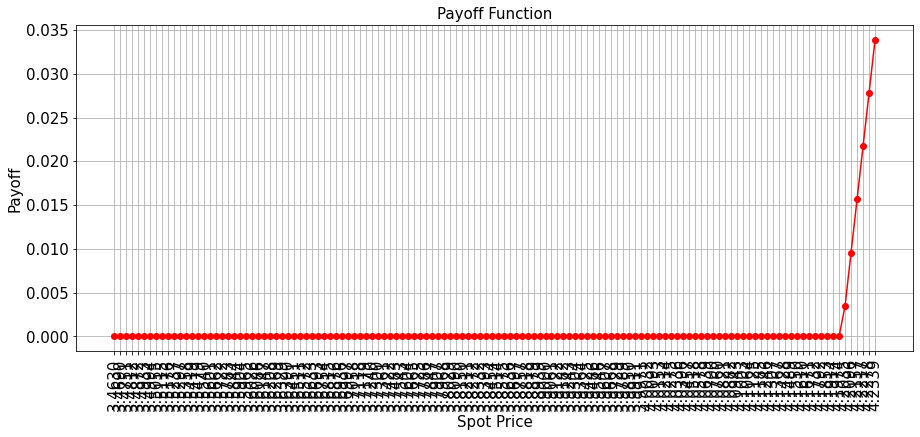

In [181]:
x1 = []
y1 = []

for i in range(len(Clientes_Trading)):

    x = uncertainty_model[i].values
    y = np.maximum(0, x - Clientes_Trading['Exercise_Price'][i] )
    
    x1.append(x)
    y1.append(y)
    
    plt.figure(figsize=(15,6))
    plt.plot(x, y, "ro-")
    plt.grid()
    plt.title("Payoff Function", size=15)
    plt.xlabel("Spot Price", size=15)
    plt.ylabel("Payoff", size=15)
    plt.xticks(x, size=15, rotation=90)
    plt.yticks(size=15)
    plt.show()

    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define variables
exercise_price = Clientes_Trading['Exercise_Price'][i]  # Replace with the specific strike price
x = np.linspace(0, 2 * exercise_price, 100)  # Adjust range as needed for clarity

# Calculate payoff from the seller's perspective (negative of the buyer's payoff)
payoff_seller = -np.maximum(0, x - exercise_price)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, payoff_seller, label="Payoff as Seller", color="red")
plt.axhline(0, color='black', linestyle='--', linewidth=0.7)
plt.axvline(exercise_price, color='grey', linestyle='--', linewidth=0.7)
plt.xlabel('Underlying Asset Price at Expiration')
plt.ylabel('Payoff')
plt.title('Option Payoff from Seller\'s Perspective')
plt.legend()
plt.grid(True)
plt.show()


In [502]:
Clientes_Trading

,Trade Id,Internal Reference,Bundle Type,Bundle Name,CounterParty_External Ref,CounterParty_Full Name,Book,Product Description,Put/Call,Buy/Sell,...,Foreign_Rate,Domestic_Rate,Vol,mu,sigma,mean,variance,stddev,low,high
0,1336003,NaN,FXO CallSpread,FXO CallSpread-391879,90283097,BANK OF AMERICA NA,FX_OPTION_TRADING,FXOption/VANILLA/(C)USD/PEN(P)/SELL/10/04/2023...,CALL USD,Sell,...,0.046513,0.079091,0.10543,1.345679,0.056119,3.846845,0.046679,0.216052,2.982637,4.711053
1,1337496,NaN,FXO CallSpread,FXO CallSpread-391964,90961947,BANCO SANTANDER NEW YORK,FX_OPTION_TRADING,FXOption/VANILLA/(C)USD/PEN(P)/SELL/10/04/2023...,CALL USD,Sell,...,0.046513,0.079091,0.10543,1.345679,0.056119,3.846845,0.046679,0.216052,2.982637,4.711053
2,1336002,NaN,FXO CallSpread,FXO CallSpread-391879,90283097,BANK OF AMERICA NA,FX_OPTION_TRADING,FXOption/VANILLA/(C)USD/PEN(P)/BUY/10/04/2023 ...,CALL USD,Buy,...,0.046513,0.082066,0.10543,1.346521,0.056119,3.850089,0.046757,0.216234,2.985152,4.715026
3,1333405,NaN,FXO CallSpread,FXO CallSpread-391744,92355927,MORGAN STANLEY CAPITAL SERVICES,FX_OPTION_TRADING,FXOption/VANILLA/(C)USD/PEN(P)/BUY/10/04/2023 ...,CALL USD,Buy,...,0.046513,0.082066,0.10543,1.346521,0.056119,3.850089,0.046757,0.216234,2.985152,4.715026
4,1334346,NaN,FXO CallSpread,FXO CallSpread-391781,92355927,MORGAN STANLEY CAPITAL SERVICES,FX_OPTION_TRADING,FXOption/VANILLA/(C)USD/PEN(P)/BUY/10/04/2023 ...,CALL USD,Buy,...,0.046513,0.082066,0.10543,1.346521,0.056119,3.850089,0.046757,0.216234,2.985152,4.715026
5,1333406,NaN,FXO CallSpread,FXO CallSpread-391744,92355927,MORGAN STANLEY CAPITAL SERVICES,FX_OPTION_TRADING,FXOption/VANILLA/(C)USD/PEN(P)/SELL/10/04/2023...,CALL USD,Sell,...,0.046513,0.079091,0.10543,1.345679,0.056119,3.846845,0.046679,0.216052,2.982637,4.711053
6,1371150,NaN,FXO CallSpread,FXO CallSpread-395224,90283097,BANK OF AMERICA NA,FX_OPTION_TRADING,FXOption/VANILLA/(C)USD/PEN(P)/BUY/10/05/2023 ...,CALL USD,Buy,...,0.047002,0.080352,0.10625,1.348182,0.064338,3.858395,0.061751,0.248497,2.864407,4.852382
7,1366649,NaN,FXO CallSpread,FXO CallSpread-394995,92355927,MORGAN STANLEY CAPITAL SERVICES,FX_OPTION_TRADING,FXOption/VANILLA/(C)USD/PEN(P)/SELL/10/05/2023...,CALL USD,Sell,...,0.047002,0.077896,0.10625,1.347281,0.064338,3.854921,0.061640,0.248273,2.861829,4.848014
8,1371151,NaN,FXO CallSpread,FXO CallSpread-395224,90283097,BANK OF AMERICA NA,FX_OPTION_TRADING,FXOption/VANILLA/(C)USD/PEN(P)/SELL/10/05/2023...,CALL USD,Sell,...,0.047002,0.077896,0.10625,1.347281,0.064338,3.854921,0.061640,0.248273,2.861829,4.848014
9,1366648,NaN,FXO CallSpread,FXO CallSpread-394995,92355927,MORGAN STANLEY CAPITAL SERVICES,FX_OPTION_TRADING,FXOption/VANILLA/(C)USD/PEN(P)/BUY/10/05/2023 ...,CALL USD,Buy,...,0.047002,0.080352,0.10625,1.348182,0.064338,3.858395,0.061751,0.248497,2.864407,4.852382


In [503]:
Clientes_Trading['Quantity']

0    -1400000
1     -400000
2     1400000
3     3000000
4     3000000
5    -3000000
6     4000000
7    -3250000
8    -4000000
9     3250000
Name: Quantity, dtype: object

In [504]:
Clientes_Trading['Exercise_Price']

0    4.10
1    4.10
2    3.90
3    3.90
4    3.90
5    4.10
6    3.80
7    4.05
8    3.95
9    3.85
Name: Exercise_Price, dtype: float64

In [505]:
Clientes_Trading['Vol']

0    0.10543
1    0.10543
2    0.10543
3    0.10543
4    0.10543
5    0.10543
6    0.10625
7    0.10625
8    0.10625
9    0.10625
Name: Vol, dtype: float64

In [506]:
Spot

3.8115

In [507]:
optionPrices = []
optionPremiums = []
optionDeltas = []
optionDeltasUSD = []

for i in range(len(Clientes_Trading)):
    
    exact_value = np.dot(uncertainty_model[i].probabilities, y1[i]) #this is the opton price
    exact_premium = (Clientes_Trading['Quantity'][i]*-1*exact_value)/Spot
    exact_delta = sum(uncertainty_model[i].probabilities[x1[i] >= Clientes_Trading['Exercise_Price'][i]])
    exact_deltaUSD = Clientes_Trading['Quantity'][i] * exact_delta

    optionPrices.append(exact_value)
    optionPremiums.append(exact_premium)
    optionDeltas.append(exact_delta)
    optionDeltasUSD.append(exact_deltaUSD)
    

    print("Notional:\t%.2f" %Clientes_Trading['Quantity'][i])
    print("exact expected value:\t%.6f" % exact_value)
    print("exact expected premium:\t%.2f" % exact_premium)
    print("exact delta value:   \t%.4f" % exact_delta)
    print("exact delta USD:   \t%.2f" % exact_deltaUSD)

Notional:	-1400000.00
exact expected value:	1285.606551
exact expected premium:	472215445.77
exact delta value:   	0.0000
exact delta USD:   	0.00
Notional:	-400000.00
exact expected value:	1344.579044
exact expected premium:	141107600.07
exact delta value:   	0.0072
exact delta USD:   	-2872.30
Notional:	1400000.00
exact expected value:	672.289522
exact expected premium:	-246938300.12
exact delta value:   	0.2995
exact delta USD:   	419354.94
Notional:	3000000.00
exact expected value:	36.567346
exact expected premium:	-28781854.06
exact delta value:   	0.2995
exact delta USD:   	898617.73
Traceback (most recent call last):
  Input In [507] in <cell line: 6>
    exact_value = np.dot(uncertainty_model[i].probabilities, y1[i]) #this is the opton price
IndexError: list index out of range

Use %tb to get the full traceback.


In [508]:
optionPrices

[1285.6065511156846, 1344.579044159234, 672.2895220796202, 36.56734558307362]

In [90]:
optionPremiums

[2697.5867306681266, 2461.389364986464, 1230.694682493232, 56.81525057019457]

In [188]:
## Aqui deberia hacer lo que sale en el Excel:

Clientes_Trading['Strike']

0    3.99
1    4.10
2    4.10
3    4.20
Name: Strike, dtype: float64

In [189]:
Clientes_Trading['Quantity']

0    -20000000
1    -20000000
2    -10000000
3    -20000000
Name: Quantity, dtype: object

In [191]:
notionalFX = abs(Clientes_Trading['Quantity']/Clientes_Trading['Strike'])
notionalFX

0    5012531.328321
1    4878048.780488
2    2439024.390244
3    4761904.761905
dtype: object

In [195]:
optionPremiums

[2697.5867306681266, 2461.389364986464, 1230.694682493232, 56.81525057019457]

In [197]:
max(15,2)

15

In [199]:
quantumPayoff = optionPremiums[0] - max(4.10 - Clientes_Trading['Strike'][0],0)* notionalFX[0]
quantumPayoff

-548680.8593846173

In [216]:
quantumPayoff

-548680.8593846173

In [221]:
uncertainty_model

In [251]:
uncertainty_model[0].values


array([3.59380926, 3.5977251 , 3.60164095, 3.60555679, 3.60947264,
       3.61338848, 3.61730432, 3.62122017, 3.62513601, 3.62905186,
       3.6329677 , 3.63688355, 3.64079939, 3.64471524, 3.64863108,
       3.65254692, 3.65646277, 3.66037861, 3.66429446, 3.6682103 ,
       3.67212615, 3.67604199, 3.67995784, 3.68387368, 3.68778953,
       3.69170537, 3.69562121, 3.69953706, 3.7034529 , 3.70736875,
       3.71128459, 3.71520044, 3.71911628, 3.72303213, 3.72694797,
       3.73086381, 3.73477966, 3.7386955 , 3.74261135, 3.74652719,
       3.75044304, 3.75435888, 3.75827473, 3.76219057, 3.76610642,
       3.77002226, 3.7739381 , 3.77785395, 3.78176979, 3.78568564,
       3.78960148, 3.79351733, 3.79743317, 3.80134902, 3.80526486,
       3.8091807 , 3.81309655, 3.81701239, 3.82092824, 3.82484408,
       3.82875993, 3.83267577, 3.83659162, 3.84050746, 3.84442331,
       3.84833915, 3.85225499, 3.85617084, 3.86008668, 3.86400253,
       3.86791837, 3.87183422, 3.87575006, 3.87966591, 3.88358

In [254]:
quantumPayoffList = []

for i in range(len(Clientes_Trading)):
    for j in range(len(uncertainty_model[0].values)):
        
        qcPayoff = optionPremiums[i] - max(uncertainty_model[i].values[j] - Clientes_Trading['Strike'][i],0)* notionalFX[i]
        quantumPayoffList.append(qcPayoff)


        

In [267]:
print(quantumPayoffList[0:(len(uncertainty_model[0].values))])
print(quantumPayoffList[len(uncertainty_model[0].values):(len(uncertainty_model[0].values)*2)])
print(quantumPayoffList[len(uncertainty_model[0].values)*2:(len(uncertainty_model[0].values)*3)])
print(quantumPayoffList[len(uncertainty_model[0].values)*3:(len(uncertainty_model[0].values)*4)])

[2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266, 2697.5867306681266,

In [268]:
quantumPL = [(quantumPayoffList[0:(len(uncertainty_model[0].values))]),
(quantumPayoffList[len(uncertainty_model[0].values):(len(uncertainty_model[0].values)*2)]),
(quantumPayoffList[len(uncertainty_model[0].values)*2:(len(uncertainty_model[0].values)*3)]),
(quantumPayoffList[len(uncertainty_model[0].values)*3:(len(uncertainty_model[0].values)*4)])]

In [270]:
quantumPL[0]

[2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306681266,
 2697.5867306

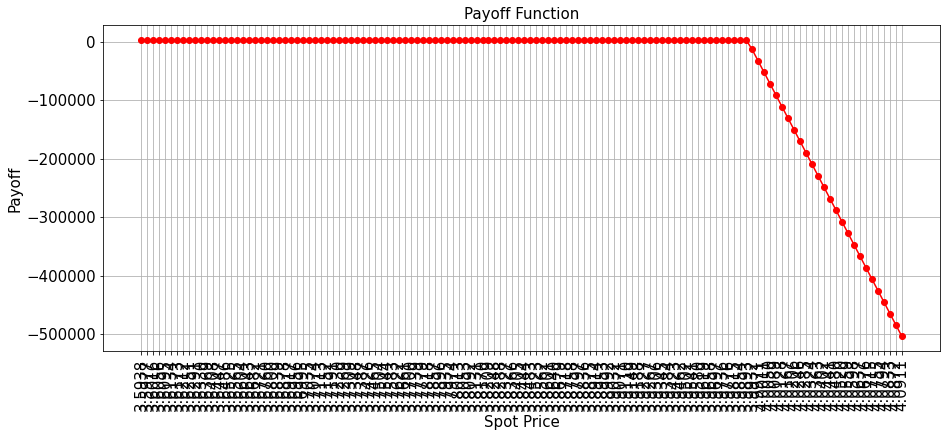

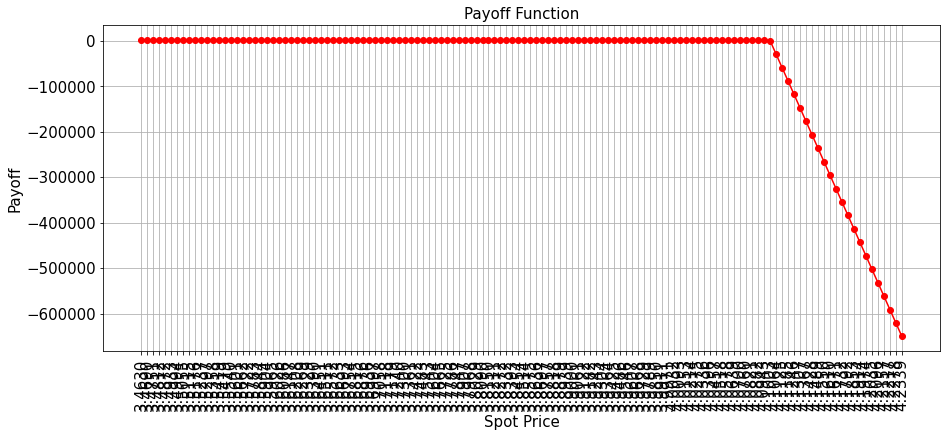

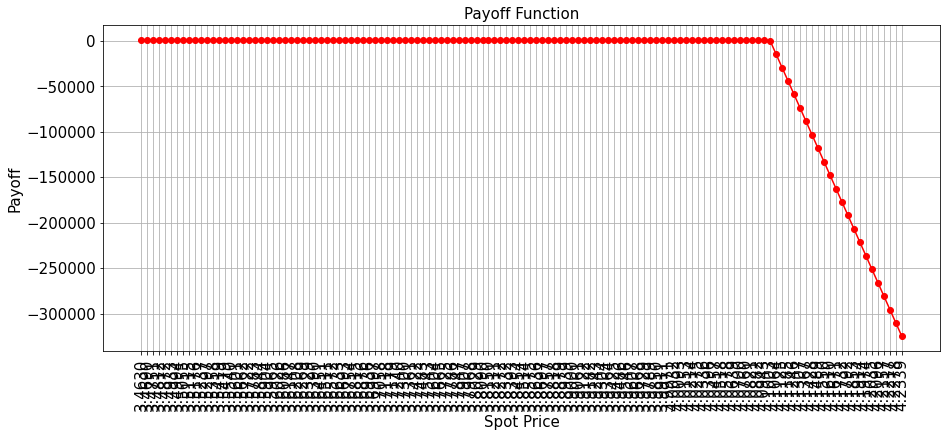

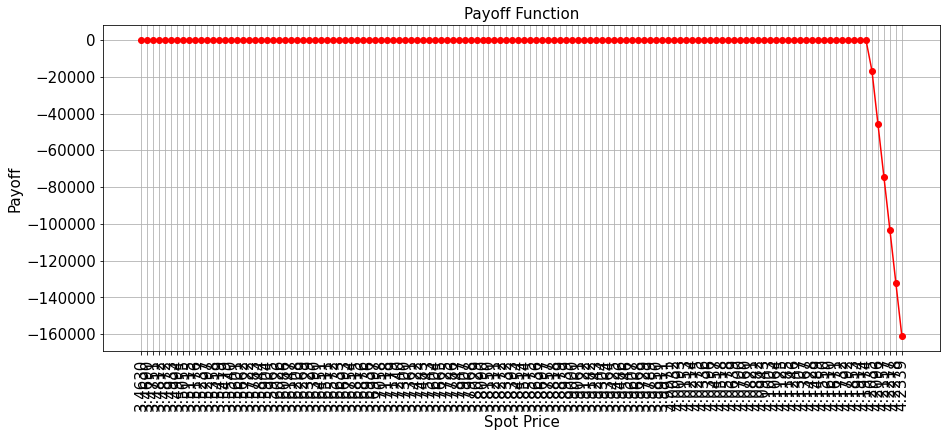

In [271]:
x1 = []
y1 = []

for i in range(len(Clientes_Trading)):

    x = uncertainty_model[i].values
    y = quantumPL[i]
    
    x1.append(x)
    y1.append(y)
    
    plt.figure(figsize=(15,6))
    plt.plot(x, y, "ro-")
    plt.grid()
    plt.title("Payoff Function", size=15)
    plt.xlabel("Spot Price", size=15)
    plt.ylabel("Payoff", size=15)
    plt.xticks(x, size=15, rotation=90)
    plt.yticks(size=15)
    plt.show()


In [275]:
pnlTable = [quantumPL[0], uncertainty_model[0].values ]
pnlTable = pd.DataFrame(pnlTable)
pnlTable

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,2697.586731,2697.586731,2697.586731,2697.586731,2697.586731,2697.586731,2697.586731,2697.586731,2697.586731,2697.586731,...,-327522.504790,-347150.798035,-366779.091279,-386407.384523,-406035.677767,-425663.971012,-445292.264256,-464920.55750,-484548.850745,-504177.143989
1,3.593809,3.597725,3.601641,3.605557,3.609473,3.613388,3.617304,3.621220,3.625136,3.629052,...,4.055879,4.059795,4.063711,4.067626,4.071542,4.075458,4.079374,4.08329,4.087206,4.091122


In [277]:
pnlTable.transpose()

,0,1
0,2697.586731,3.593809
1,2697.586731,3.597725
2,2697.586731,3.601641
3,2697.586731,3.605557
4,2697.586731,3.609473
...,...,...
123,-425663.971012,4.075458
124,-445292.264256,4.079374
125,-464920.557500,4.083290
126,-484548.850745,4.087206


## Delta evaluation

In [88]:
european_call_delta = EuropeanCallDelta(
    num_state_qubits=num_uncertainty_qubits,
    strike_price=strike_price,
    bounds=(low, high),
    uncertainty_model=uncertainty_model,
)

Traceback (most recent call last):
  Input In [88] in <cell line: 1>
    strike_price=strike_price,
NameError: name 'strike_price' is not defined

Use %tb to get the full traceback.


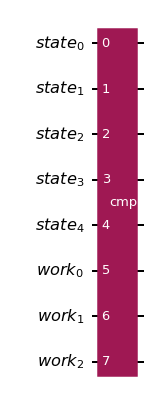

In [25]:
european_call_delta._objective.decompose().draw('mpl', style='iqx')

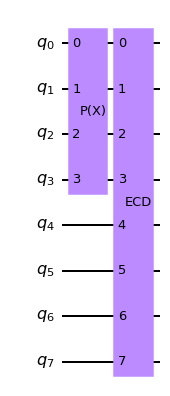

In [26]:
european_call_delta_circ = QuantumCircuit(european_call_delta._objective.num_qubits)
european_call_delta_circ.append(uncertainty_model, range(num_uncertainty_qubits))
european_call_delta_circ.append(
    european_call_delta._objective, range(european_call_delta._objective.num_qubits)
)

european_call_delta_circ.draw()

In [27]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
problem = european_call_delta.to_estimation_problem()

# construct amplitude estimation
ae_delta = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)

In [28]:
result_delta = ae_delta.estimate(problem)

In [29]:
conf_int = np.array(result_delta.confidence_interval_processed)
print("Exact delta:    \t%.4f" % exact_delta)
print("Esimated value: \t%.4f" % european_call_delta.interpret(result_delta))
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact delta:    	0.2067
Esimated value: 	0.2068
Confidence interval: 	[0.2023, 0.2112]


## BCP Quantum FX Option Pricing - Puts

In [ ]:
# Faltan Puts aqui

In [48]:
slopes = [[-1, 0]] * len(Clientes_Trading)
offsets = [[Clientes_Trading['Exercise_Price']-Clientes_Trading['low'], 0]] * len(Clientes_Trading)
f_min = [0] * len(Clientes_Trading)
f_max = [Clientes_Trading['Exercise_Price']-Clientes_Trading['low']]

In [49]:
european_put_objective = []

for i in range(len(Clientes_Trading)):

    optionPut = LinearAmplitudeFunction(num_uncertainty_qubits, slopes[i], offsets[i], domain=domain[i], image=(f_min[i], f_max[i]), breakpoints=breakpoints[i], rescaling_factor= c_approx,)
    european_put_objective.append(optionPut)
    print(european_put_objective)

Traceback (most recent call last):
  Input In [49] in <cell line: 3>
    optionPut = LinearAmplitudeFunction(num_uncertainty_qubits, slopes[i], offsets[i], domain=domain[i], image=(f_min[i], f_max[i]), breakpoints=breakpoints[i], rescaling_factor= c_approx,)
  File /opt/conda/lib/python3.8/site-packages/qiskit/circuit/library/arithmetic/linear_amplitude_function.py:143 in __init__
    slope_angles[i] = np.pi * rescaling_factor * mapped_slope[i] / 2 / (d - c)
ValueError: setting an array element with a sequence.

Use %tb to get the full traceback.
